In [1]:
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from datetime import datetime
import pandas as pd
import numpy as np
import requests
import warnings
import talib
import json
import time

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
warnings.filterwarnings("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (20,10)

In [3]:
patternList = [talib.CDL2CROWS, talib.CDL3BLACKCROWS, talib.CDL3INSIDE, talib.CDL3LINESTRIKE, talib.CDL3OUTSIDE, talib.CDL3STARSINSOUTH, talib.CDL3WHITESOLDIERS, talib.CDLABANDONEDBABY, talib.CDLADVANCEBLOCK, talib.CDLBELTHOLD, talib.CDLBREAKAWAY, talib.CDLCLOSINGMARUBOZU, talib.CDLCONCEALBABYSWALL, talib.CDLCOUNTERATTACK, talib.CDLDARKCLOUDCOVER, talib.CDLDOJI, talib.CDLDOJISTAR, talib.CDLDRAGONFLYDOJI, talib.CDLENGULFING, talib.CDLEVENINGDOJISTAR, talib.CDLEVENINGSTAR, talib.CDLGAPSIDESIDEWHITE, talib.CDLGRAVESTONEDOJI, talib.CDLHAMMER, talib.CDLHANGINGMAN, talib.CDLHARAMI, talib.CDLHARAMICROSS, talib.CDLHIGHWAVE, talib.CDLHIKKAKE, talib.CDLHIKKAKEMOD, talib.CDLHOMINGPIGEON, talib.CDLIDENTICAL3CROWS, talib.CDLINNECK, talib.CDLINVERTEDHAMMER, talib.CDLKICKING, talib.CDLKICKINGBYLENGTH, talib.CDLLADDERBOTTOM, talib.CDLLONGLEGGEDDOJI, talib.CDLLONGLINE, talib.CDLMARUBOZU, talib.CDLMATCHINGLOW, talib.CDLMATHOLD, talib.CDLMORNINGDOJISTAR, talib.CDLMORNINGSTAR, talib.CDLONNECK, talib.CDLPIERCING, talib.CDLRICKSHAWMAN, talib.CDLRISEFALL3METHODS, talib.CDLSEPARATINGLINES, talib.CDLSHOOTINGSTAR, talib.CDLSHORTLINE, talib.CDLSPINNINGTOP, talib.CDLSTALLEDPATTERN, talib.CDLSTICKSANDWICH, talib.CDLTAKURI, talib.CDLTASUKIGAP, talib.CDLTHRUSTING, talib.CDLTRISTAR, talib.CDLUNIQUE3RIVER, talib.CDLUPSIDEGAP2CROWS, talib.CDLXSIDEGAP3METHODS]

In [4]:
dictOfPatterns = {i: list() for i in patternList}

In [5]:
header = {
          "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:92.0) Gecko/20100101 Firefox/92.0",
          "X-Requested-With": "XMLHttpRequest"
        }

In [6]:
url = 'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/listing?start=1&limit=500&sortBy=market_cap&sortType=desc&convert=USD,BTC,ETH&cryptoType=all&tagType=all&audited=false&aux=ath,atl,high24h,low24h,num_market_pairs,cmc_rank,date_added,max_supply,circulating_supply,total_supply,volume_7d,volume_30d'
r = requests.get(url, headers=header)
rawData = r.json()['data']['cryptoCurrencyList']
tickerList = [i['symbol'] for i in rawData]
idList = [i['id'] for i in rawData]

url = 'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/listing?start=1&limit=500&sortBy=market_cap&sortType=desc&convert=USD,BTC,ETH&cryptoType=all&tagType=all&audited=false&aux=ath,atl,high24h,low24h,num_market_pairs,cmc_rank,date_added,tags,platform,max_supply,circulating_supply,total_supply,volume_7d,volume_30d&tagSlugs=stablecoin'
r = requests.get(url, headers=header)
rawData = r.json()['data']['cryptoCurrencyList']
stablecoinList = [i['symbol'] for i in rawData]
stablecoinIdList = [i['id'] for i in rawData]

tickerList = [i for i in tickerList if i not in stablecoinList]
idList = [i for i in idList if i not in stablecoinIdList]

In [7]:
%%time
totalNoOfDays = 0
for (ticker, tickerId) in zip(tickerList, idList):
    try:
        period1 = int(time.time() - 1633974477) #eternity
        period2 = int(time.time())
        url = f'https://api.coinmarketcap.com/data-api/v3/cryptocurrency/historical?id={tickerId}&convertId=2781&timeStart={period1}&timeEnd={period2}'
        r = requests.get(url, headers=header)
        rawData = r.json()['data']['quotes']

        timestamp = [rawData[i]['quote']['timestamp'] for i in range(len(rawData))]
        openList = [rawData[i]['quote']['open'] for i in range(len(rawData))]
        highList = [rawData[i]['quote']['high'] for i in range(len(rawData))]
        lowList = [rawData[i]['quote']['low'] for i in range(len(rawData))]
        closeList = [rawData[i]['quote']['close'] for i in range(len(rawData))]
        
        timestamp = [i for i in timestamp if i != None]
        openList = [i for i in openList if i != None]
        highList = [i for i in highList if i != None]
        lowList = [i for i in lowList if i != None]
        closeList = [i for i in closeList if i != None]

        dataframe = pd.DataFrame(list(zip(timestamp, openList, highList, lowList, closeList)), columns=['timestamp', 'open', 'high', 'low', 'close'])
        totalNoOfDays = totalNoOfDays + len(dataframe)

        for pattern in patternList:
            dataframe['pattern'] = pattern(dataframe.open, dataframe.high, dataframe.low, dataframe.close)
            dataframe['shiftedReturn'] = np.log(dataframe['close'].shift(-1)/dataframe['close'])*100
            dataframe['realizedReturn'] = np.where(dataframe['pattern'] == -100, dataframe['shiftedReturn']*-1, dataframe['shiftedReturn'])
            dataframe.dropna(inplace=True)
            print(str(pattern)[10:-23],'for',ticker)
            dictOfPatterns[pattern] = dictOfPatterns[pattern] + list(dataframe[dataframe['pattern'] == 100]['realizedReturn'])
    except:
        pass

CDL2CROWS for BTC
CDL3BLACKCROWS for BTC
CDL3INSIDE for BTC
CDL3LINESTRIKE for BTC
CDL3OUTSIDE for BTC
CDL3STARSINSOUTH for BTC
CDL3WHITESOLDIERS for BTC
CDLABANDONEDBABY for BTC
CDLADVANCEBLOCK for BTC
CDLBELTHOLD for BTC
CDLBREAKAWAY for BTC
CDLCLOSINGMARUBOZU for BTC
CDLCONCEALBABYSWALL for BTC
CDLCOUNTERATTACK for BTC
CDLDARKCLOUDCOVER for BTC
CDLDOJI for BTC
CDLDOJISTAR for BTC
CDLDRAGONFLYDOJI for BTC
CDLENGULFING for BTC
CDLEVENINGDOJISTAR for BTC
CDLEVENINGSTAR for BTC
CDLGAPSIDESIDEWHITE for BTC
CDLGRAVESTONEDOJI for BTC
CDLHAMMER for BTC
CDLHANGINGMAN for BTC
CDLHARAMI for BTC
CDLHARAMICROSS for BTC
CDLHIGHWAVE for BTC
CDLHIKKAKE for BTC
CDLHIKKAKEMOD for BTC
CDLHOMINGPIGEON for BTC
CDLIDENTICAL3CROWS for BTC
CDLINNECK for BTC
CDLINVERTEDHAMMER for BTC
CDLKICKING for BTC
CDLKICKINGBYLENGTH for BTC
CDLLADDERBOTTOM for BTC
CDLLONGLEGGEDDOJI for BTC
CDLLONGLINE for BTC
CDLMARUBOZU for BTC
CDLMATCHINGLOW for BTC
CDLMATHOLD for BTC
CDLMORNINGDOJISTAR for BTC
CDLMORNINGSTAR for BTC

CDLTAKURI for XRP
CDLTASUKIGAP for XRP
CDLTHRUSTING for XRP
CDLTRISTAR for XRP
CDLUNIQUE3RIVER for XRP
CDLUPSIDEGAP2CROWS for XRP
CDLXSIDEGAP3METHODS for XRP
CDL2CROWS for DOT
CDL3BLACKCROWS for DOT
CDL3INSIDE for DOT
CDL3LINESTRIKE for DOT
CDL3OUTSIDE for DOT
CDL3STARSINSOUTH for DOT
CDL3WHITESOLDIERS for DOT
CDLABANDONEDBABY for DOT
CDLADVANCEBLOCK for DOT
CDLBELTHOLD for DOT
CDLBREAKAWAY for DOT
CDLCLOSINGMARUBOZU for DOT
CDLCONCEALBABYSWALL for DOT
CDLCOUNTERATTACK for DOT
CDLDARKCLOUDCOVER for DOT
CDLDOJI for DOT
CDLDOJISTAR for DOT
CDLDRAGONFLYDOJI for DOT
CDLENGULFING for DOT
CDLEVENINGDOJISTAR for DOT
CDLEVENINGSTAR for DOT
CDLGAPSIDESIDEWHITE for DOT
CDLGRAVESTONEDOJI for DOT
CDLHAMMER for DOT
CDLHANGINGMAN for DOT
CDLHARAMI for DOT
CDLHARAMICROSS for DOT
CDLHIGHWAVE for DOT
CDLHIKKAKE for DOT
CDLHIKKAKEMOD for DOT
CDLHOMINGPIGEON for DOT
CDLIDENTICAL3CROWS for DOT
CDLINNECK for DOT
CDLINVERTEDHAMMER for DOT
CDLKICKING for DOT
CDLKICKINGBYLENGTH for DOT
CDLLADDERBOTTOM for DOT

CDL2CROWS for LINK
CDL3BLACKCROWS for LINK
CDL3INSIDE for LINK
CDL3LINESTRIKE for LINK
CDL3OUTSIDE for LINK
CDL3STARSINSOUTH for LINK
CDL3WHITESOLDIERS for LINK
CDLABANDONEDBABY for LINK
CDLADVANCEBLOCK for LINK
CDLBELTHOLD for LINK
CDLBREAKAWAY for LINK
CDLCLOSINGMARUBOZU for LINK
CDLCONCEALBABYSWALL for LINK
CDLCOUNTERATTACK for LINK
CDLDARKCLOUDCOVER for LINK
CDLDOJI for LINK
CDLDOJISTAR for LINK
CDLDRAGONFLYDOJI for LINK
CDLENGULFING for LINK
CDLEVENINGDOJISTAR for LINK
CDLEVENINGSTAR for LINK
CDLGAPSIDESIDEWHITE for LINK
CDLGRAVESTONEDOJI for LINK
CDLHAMMER for LINK
CDLHANGINGMAN for LINK
CDLHARAMI for LINK
CDLHARAMICROSS for LINK
CDLHIGHWAVE for LINK
CDLHIKKAKE for LINK
CDLHIKKAKEMOD for LINK
CDLHOMINGPIGEON for LINK
CDLIDENTICAL3CROWS for LINK
CDLINNECK for LINK
CDLINVERTEDHAMMER for LINK
CDLKICKING for LINK
CDLKICKINGBYLENGTH for LINK
CDLLADDERBOTTOM for LINK
CDLLONGLEGGEDDOJI for LINK
CDLLONGLINE for LINK
CDLMARUBOZU for LINK
CDLMATCHINGLOW for LINK
CDLMATHOLD for LINK
CDLMORN

CDLSHORTLINE for BCH
CDLSPINNINGTOP for BCH
CDLSTALLEDPATTERN for BCH
CDLSTICKSANDWICH for BCH
CDLTAKURI for BCH
CDLTASUKIGAP for BCH
CDLTHRUSTING for BCH
CDLTRISTAR for BCH
CDLUNIQUE3RIVER for BCH
CDLUPSIDEGAP2CROWS for BCH
CDLXSIDEGAP3METHODS for BCH
CDL2CROWS for VET
CDL3BLACKCROWS for VET
CDL3INSIDE for VET
CDL3LINESTRIKE for VET
CDL3OUTSIDE for VET
CDL3STARSINSOUTH for VET
CDL3WHITESOLDIERS for VET
CDLABANDONEDBABY for VET
CDLADVANCEBLOCK for VET
CDLBELTHOLD for VET
CDLBREAKAWAY for VET
CDLCLOSINGMARUBOZU for VET
CDLCONCEALBABYSWALL for VET
CDLCOUNTERATTACK for VET
CDLDARKCLOUDCOVER for VET
CDLDOJI for VET
CDLDOJISTAR for VET
CDLDRAGONFLYDOJI for VET
CDLENGULFING for VET
CDLEVENINGDOJISTAR for VET
CDLEVENINGSTAR for VET
CDLGAPSIDESIDEWHITE for VET
CDLGRAVESTONEDOJI for VET
CDLHAMMER for VET
CDLHANGINGMAN for VET
CDLHARAMI for VET
CDLHARAMICROSS for VET
CDLHIGHWAVE for VET
CDLHIKKAKE for VET
CDLHIKKAKEMOD for VET
CDLHOMINGPIGEON for VET
CDLIDENTICAL3CROWS for VET
CDLINNECK for VET


CDLTASUKIGAP for ATOM
CDLTHRUSTING for ATOM
CDLTRISTAR for ATOM
CDLUNIQUE3RIVER for ATOM
CDLUPSIDEGAP2CROWS for ATOM
CDLXSIDEGAP3METHODS for ATOM
CDL2CROWS for FTT
CDL3BLACKCROWS for FTT
CDL3INSIDE for FTT
CDL3LINESTRIKE for FTT
CDL3OUTSIDE for FTT
CDL3STARSINSOUTH for FTT
CDL3WHITESOLDIERS for FTT
CDLABANDONEDBABY for FTT
CDLADVANCEBLOCK for FTT
CDLBELTHOLD for FTT
CDLBREAKAWAY for FTT
CDLCLOSINGMARUBOZU for FTT
CDLCONCEALBABYSWALL for FTT
CDLCOUNTERATTACK for FTT
CDLDARKCLOUDCOVER for FTT
CDLDOJI for FTT
CDLDOJISTAR for FTT
CDLDRAGONFLYDOJI for FTT
CDLENGULFING for FTT
CDLEVENINGDOJISTAR for FTT
CDLEVENINGSTAR for FTT
CDLGAPSIDESIDEWHITE for FTT
CDLGRAVESTONEDOJI for FTT
CDLHAMMER for FTT
CDLHANGINGMAN for FTT
CDLHARAMI for FTT
CDLHARAMICROSS for FTT
CDLHIGHWAVE for FTT
CDLHIKKAKE for FTT
CDLHIKKAKEMOD for FTT
CDLHOMINGPIGEON for FTT
CDLIDENTICAL3CROWS for FTT
CDLINNECK for FTT
CDLINVERTEDHAMMER for FTT
CDLKICKING for FTT
CDLKICKINGBYLENGTH for FTT
CDLLADDERBOTTOM for FTT
CDLLONGLEGG

CDLTAKURI for ETC
CDLTASUKIGAP for ETC
CDLTHRUSTING for ETC
CDLTRISTAR for ETC
CDLUNIQUE3RIVER for ETC
CDLUPSIDEGAP2CROWS for ETC
CDLXSIDEGAP3METHODS for ETC
CDL2CROWS for BTCB
CDL3BLACKCROWS for BTCB
CDL3INSIDE for BTCB
CDL3LINESTRIKE for BTCB
CDL3OUTSIDE for BTCB
CDL3STARSINSOUTH for BTCB
CDL3WHITESOLDIERS for BTCB
CDLABANDONEDBABY for BTCB
CDLADVANCEBLOCK for BTCB
CDLBELTHOLD for BTCB
CDLBREAKAWAY for BTCB
CDLCLOSINGMARUBOZU for BTCB
CDLCONCEALBABYSWALL for BTCB
CDLCOUNTERATTACK for BTCB
CDLDARKCLOUDCOVER for BTCB
CDLDOJI for BTCB
CDLDOJISTAR for BTCB
CDLDRAGONFLYDOJI for BTCB
CDLENGULFING for BTCB
CDLEVENINGDOJISTAR for BTCB
CDLEVENINGSTAR for BTCB
CDLGAPSIDESIDEWHITE for BTCB
CDLGRAVESTONEDOJI for BTCB
CDLHAMMER for BTCB
CDLHANGINGMAN for BTCB
CDLHARAMI for BTCB
CDLHARAMICROSS for BTCB
CDLHIGHWAVE for BTCB
CDLHIKKAKE for BTCB
CDLHIKKAKEMOD for BTCB
CDLHOMINGPIGEON for BTCB
CDLIDENTICAL3CROWS for BTCB
CDLINNECK for BTCB
CDLINVERTEDHAMMER for BTCB
CDLKICKING for BTCB
CDLKICKINGBYLEN

CDL2CROWS for GRT
CDL3BLACKCROWS for GRT
CDL3INSIDE for GRT
CDL3LINESTRIKE for GRT
CDL3OUTSIDE for GRT
CDL3STARSINSOUTH for GRT
CDL3WHITESOLDIERS for GRT
CDLABANDONEDBABY for GRT
CDLADVANCEBLOCK for GRT
CDLBELTHOLD for GRT
CDLBREAKAWAY for GRT
CDLCLOSINGMARUBOZU for GRT
CDLCONCEALBABYSWALL for GRT
CDLCOUNTERATTACK for GRT
CDLDARKCLOUDCOVER for GRT
CDLDOJI for GRT
CDLDOJISTAR for GRT
CDLDRAGONFLYDOJI for GRT
CDLENGULFING for GRT
CDLEVENINGDOJISTAR for GRT
CDLEVENINGSTAR for GRT
CDLGAPSIDESIDEWHITE for GRT
CDLGRAVESTONEDOJI for GRT
CDLHAMMER for GRT
CDLHANGINGMAN for GRT
CDLHARAMI for GRT
CDLHARAMICROSS for GRT
CDLHIGHWAVE for GRT
CDLHIKKAKE for GRT
CDLHIKKAKEMOD for GRT
CDLHOMINGPIGEON for GRT
CDLIDENTICAL3CROWS for GRT
CDLINNECK for GRT
CDLINVERTEDHAMMER for GRT
CDLKICKING for GRT
CDLKICKINGBYLENGTH for GRT
CDLLADDERBOTTOM for GRT
CDLLONGLEGGEDDOJI for GRT
CDLLONGLINE for GRT
CDLMARUBOZU for GRT
CDLMATCHINGLOW for GRT
CDLMATHOLD for GRT
CDLMORNINGDOJISTAR for GRT
CDLMORNINGSTAR for GRT

CDL2CROWS for AAVE
CDL3BLACKCROWS for AAVE
CDL3INSIDE for AAVE
CDL3LINESTRIKE for AAVE
CDL3OUTSIDE for AAVE
CDL3STARSINSOUTH for AAVE
CDL3WHITESOLDIERS for AAVE
CDLABANDONEDBABY for AAVE
CDLADVANCEBLOCK for AAVE
CDLBELTHOLD for AAVE
CDLBREAKAWAY for AAVE
CDLCLOSINGMARUBOZU for AAVE
CDLCONCEALBABYSWALL for AAVE
CDLCOUNTERATTACK for AAVE
CDLDARKCLOUDCOVER for AAVE
CDLDOJI for AAVE
CDLDOJISTAR for AAVE
CDLDRAGONFLYDOJI for AAVE
CDLENGULFING for AAVE
CDLEVENINGDOJISTAR for AAVE
CDLEVENINGSTAR for AAVE
CDLGAPSIDESIDEWHITE for AAVE
CDLGRAVESTONEDOJI for AAVE
CDLHAMMER for AAVE
CDLHANGINGMAN for AAVE
CDLHARAMI for AAVE
CDLHARAMICROSS for AAVE
CDLHIGHWAVE for AAVE
CDLHIKKAKE for AAVE
CDLHIKKAKEMOD for AAVE
CDLHOMINGPIGEON for AAVE
CDLIDENTICAL3CROWS for AAVE
CDLINNECK for AAVE
CDLINVERTEDHAMMER for AAVE
CDLKICKING for AAVE
CDLKICKINGBYLENGTH for AAVE
CDLLADDERBOTTOM for AAVE
CDLLONGLEGGEDDOJI for AAVE
CDLLONGLINE for AAVE
CDLMARUBOZU for AAVE
CDLMATCHINGLOW for AAVE
CDLMATHOLD for AAVE
CDLMORN

CDLTASUKIGAP for XEC
CDLTHRUSTING for XEC
CDLTRISTAR for XEC
CDLUNIQUE3RIVER for XEC
CDLUPSIDEGAP2CROWS for XEC
CDLXSIDEGAP3METHODS for XEC
CDL2CROWS for ONE
CDL3BLACKCROWS for ONE
CDL3INSIDE for ONE
CDL3LINESTRIKE for ONE
CDL3OUTSIDE for ONE
CDL3STARSINSOUTH for ONE
CDL3WHITESOLDIERS for ONE
CDLABANDONEDBABY for ONE
CDLADVANCEBLOCK for ONE
CDLBELTHOLD for ONE
CDLBREAKAWAY for ONE
CDLCLOSINGMARUBOZU for ONE
CDLCONCEALBABYSWALL for ONE
CDLCOUNTERATTACK for ONE
CDLDARKCLOUDCOVER for ONE
CDLDOJI for ONE
CDLDOJISTAR for ONE
CDLDRAGONFLYDOJI for ONE
CDLENGULFING for ONE
CDLEVENINGDOJISTAR for ONE
CDLEVENINGSTAR for ONE
CDLGAPSIDESIDEWHITE for ONE
CDLGRAVESTONEDOJI for ONE
CDLHAMMER for ONE
CDLHANGINGMAN for ONE
CDLHARAMI for ONE
CDLHARAMICROSS for ONE
CDLHIGHWAVE for ONE
CDLHIKKAKE for ONE
CDLHIKKAKEMOD for ONE
CDLHOMINGPIGEON for ONE
CDLIDENTICAL3CROWS for ONE
CDLINNECK for ONE
CDLINVERTEDHAMMER for ONE
CDLKICKING for ONE
CDLKICKINGBYLENGTH for ONE
CDLLADDERBOTTOM for ONE
CDLLONGLEGGEDDOJI

CDL2CROWS for MKR
CDL3BLACKCROWS for MKR
CDL3INSIDE for MKR
CDL3LINESTRIKE for MKR
CDL3OUTSIDE for MKR
CDL3STARSINSOUTH for MKR
CDL3WHITESOLDIERS for MKR
CDLABANDONEDBABY for MKR
CDLADVANCEBLOCK for MKR
CDLBELTHOLD for MKR
CDLBREAKAWAY for MKR
CDLCLOSINGMARUBOZU for MKR
CDLCONCEALBABYSWALL for MKR
CDLCOUNTERATTACK for MKR
CDLDARKCLOUDCOVER for MKR
CDLDOJI for MKR
CDLDOJISTAR for MKR
CDLDRAGONFLYDOJI for MKR
CDLENGULFING for MKR
CDLEVENINGDOJISTAR for MKR
CDLEVENINGSTAR for MKR
CDLGAPSIDESIDEWHITE for MKR
CDLGRAVESTONEDOJI for MKR
CDLHAMMER for MKR
CDLHANGINGMAN for MKR
CDLHARAMI for MKR
CDLHARAMICROSS for MKR
CDLHIGHWAVE for MKR
CDLHIKKAKE for MKR
CDLHIKKAKEMOD for MKR
CDLHOMINGPIGEON for MKR
CDLIDENTICAL3CROWS for MKR
CDLINNECK for MKR
CDLINVERTEDHAMMER for MKR
CDLKICKING for MKR
CDLKICKINGBYLENGTH for MKR
CDLLADDERBOTTOM for MKR
CDLLONGLEGGEDDOJI for MKR
CDLLONGLINE for MKR
CDLMARUBOZU for MKR
CDLMATCHINGLOW for MKR
CDLMATHOLD for MKR
CDLMORNINGDOJISTAR for MKR
CDLMORNINGSTAR for MKR

CDL2CROWS for BTT
CDL3BLACKCROWS for BTT
CDL3INSIDE for BTT
CDL3LINESTRIKE for BTT
CDL3OUTSIDE for BTT
CDL3STARSINSOUTH for BTT
CDL3WHITESOLDIERS for BTT
CDLABANDONEDBABY for BTT
CDLADVANCEBLOCK for BTT
CDLBELTHOLD for BTT
CDLBREAKAWAY for BTT
CDLCLOSINGMARUBOZU for BTT
CDLCONCEALBABYSWALL for BTT
CDLCOUNTERATTACK for BTT
CDLDARKCLOUDCOVER for BTT
CDLDOJI for BTT
CDLDOJISTAR for BTT
CDLDRAGONFLYDOJI for BTT
CDLENGULFING for BTT
CDLEVENINGDOJISTAR for BTT
CDLEVENINGSTAR for BTT
CDLGAPSIDESIDEWHITE for BTT
CDLGRAVESTONEDOJI for BTT
CDLHAMMER for BTT
CDLHANGINGMAN for BTT
CDLHARAMI for BTT
CDLHARAMICROSS for BTT
CDLHIGHWAVE for BTT
CDLHIKKAKE for BTT
CDLHIKKAKEMOD for BTT
CDLHOMINGPIGEON for BTT
CDLIDENTICAL3CROWS for BTT
CDLINNECK for BTT
CDLINVERTEDHAMMER for BTT
CDLKICKING for BTT
CDLKICKINGBYLENGTH for BTT
CDLLADDERBOTTOM for BTT
CDLLONGLEGGEDDOJI for BTT
CDLLONGLINE for BTT
CDLMARUBOZU for BTT
CDLMATCHINGLOW for BTT
CDLMATHOLD for BTT
CDLMORNINGDOJISTAR for BTT
CDLMORNINGSTAR for BTT

CDLSTALLEDPATTERN for CELO
CDLSTICKSANDWICH for CELO
CDLTAKURI for CELO
CDLTASUKIGAP for CELO
CDLTHRUSTING for CELO
CDLTRISTAR for CELO
CDLUNIQUE3RIVER for CELO
CDLUPSIDEGAP2CROWS for CELO
CDLXSIDEGAP3METHODS for CELO
CDL2CROWS for COMP
CDL3BLACKCROWS for COMP
CDL3INSIDE for COMP
CDL3LINESTRIKE for COMP
CDL3OUTSIDE for COMP
CDL3STARSINSOUTH for COMP
CDL3WHITESOLDIERS for COMP
CDLABANDONEDBABY for COMP
CDLADVANCEBLOCK for COMP
CDLBELTHOLD for COMP
CDLBREAKAWAY for COMP
CDLCLOSINGMARUBOZU for COMP
CDLCONCEALBABYSWALL for COMP
CDLCOUNTERATTACK for COMP
CDLDARKCLOUDCOVER for COMP
CDLDOJI for COMP
CDLDOJISTAR for COMP
CDLDRAGONFLYDOJI for COMP
CDLENGULFING for COMP
CDLEVENINGDOJISTAR for COMP
CDLEVENINGSTAR for COMP
CDLGAPSIDESIDEWHITE for COMP
CDLGRAVESTONEDOJI for COMP
CDLHAMMER for COMP
CDLHANGINGMAN for COMP
CDLHARAMI for COMP
CDLHARAMICROSS for COMP
CDLHIGHWAVE for COMP
CDLHIKKAKE for COMP
CDLHIKKAKEMOD for COMP
CDLHOMINGPIGEON for COMP
CDLIDENTICAL3CROWS for COMP
CDLINNECK for COMP
CD

CDL2CROWS for LRC
CDL3BLACKCROWS for LRC
CDL3INSIDE for LRC
CDL3LINESTRIKE for LRC
CDL3OUTSIDE for LRC
CDL3STARSINSOUTH for LRC
CDL3WHITESOLDIERS for LRC
CDLABANDONEDBABY for LRC
CDLADVANCEBLOCK for LRC
CDLBELTHOLD for LRC
CDLBREAKAWAY for LRC
CDLCLOSINGMARUBOZU for LRC
CDLCONCEALBABYSWALL for LRC
CDLCOUNTERATTACK for LRC
CDLDARKCLOUDCOVER for LRC
CDLDOJI for LRC
CDLDOJISTAR for LRC
CDLDRAGONFLYDOJI for LRC
CDLENGULFING for LRC
CDLEVENINGDOJISTAR for LRC
CDLEVENINGSTAR for LRC
CDLGAPSIDESIDEWHITE for LRC
CDLGRAVESTONEDOJI for LRC
CDLHAMMER for LRC
CDLHANGINGMAN for LRC
CDLHARAMI for LRC
CDLHARAMICROSS for LRC
CDLHIGHWAVE for LRC
CDLHIKKAKE for LRC
CDLHIKKAKEMOD for LRC
CDLHOMINGPIGEON for LRC
CDLIDENTICAL3CROWS for LRC
CDLINNECK for LRC
CDLINVERTEDHAMMER for LRC
CDLKICKING for LRC
CDLKICKINGBYLENGTH for LRC
CDLLADDERBOTTOM for LRC
CDLLONGLEGGEDDOJI for LRC
CDLLONGLINE for LRC
CDLMARUBOZU for LRC
CDLMATCHINGLOW for LRC
CDLMATHOLD for LRC
CDLMORNINGDOJISTAR for LRC
CDLMORNINGSTAR for LRC

CDLTRISTAR for KCS
CDLUNIQUE3RIVER for KCS
CDLUPSIDEGAP2CROWS for KCS
CDLXSIDEGAP3METHODS for KCS
CDL2CROWS for SUSHI
CDL3BLACKCROWS for SUSHI
CDL3INSIDE for SUSHI
CDL3LINESTRIKE for SUSHI
CDL3OUTSIDE for SUSHI
CDL3STARSINSOUTH for SUSHI
CDL3WHITESOLDIERS for SUSHI
CDLABANDONEDBABY for SUSHI
CDLADVANCEBLOCK for SUSHI
CDLBELTHOLD for SUSHI
CDLBREAKAWAY for SUSHI
CDLCLOSINGMARUBOZU for SUSHI
CDLCONCEALBABYSWALL for SUSHI
CDLCOUNTERATTACK for SUSHI
CDLDARKCLOUDCOVER for SUSHI
CDLDOJI for SUSHI
CDLDOJISTAR for SUSHI
CDLDRAGONFLYDOJI for SUSHI
CDLENGULFING for SUSHI
CDLEVENINGDOJISTAR for SUSHI
CDLEVENINGSTAR for SUSHI
CDLGAPSIDESIDEWHITE for SUSHI
CDLGRAVESTONEDOJI for SUSHI
CDLHAMMER for SUSHI
CDLHANGINGMAN for SUSHI
CDLHARAMI for SUSHI
CDLHARAMICROSS for SUSHI
CDLHIGHWAVE for SUSHI
CDLHIKKAKE for SUSHI
CDLHIKKAKEMOD for SUSHI
CDLHOMINGPIGEON for SUSHI
CDLIDENTICAL3CROWS for SUSHI
CDLINNECK for SUSHI
CDLINVERTEDHAMMER for SUSHI
CDLKICKING for SUSHI
CDLKICKINGBYLENGTH for SUSHI
CDLLADDERBO

CDLXSIDEGAP3METHODS for REV
CDL2CROWS for RVN
CDL3BLACKCROWS for RVN
CDL3INSIDE for RVN
CDL3LINESTRIKE for RVN
CDL3OUTSIDE for RVN
CDL3STARSINSOUTH for RVN
CDL3WHITESOLDIERS for RVN
CDLABANDONEDBABY for RVN
CDLADVANCEBLOCK for RVN
CDLBELTHOLD for RVN
CDLBREAKAWAY for RVN
CDLCLOSINGMARUBOZU for RVN
CDLCONCEALBABYSWALL for RVN
CDLCOUNTERATTACK for RVN
CDLDARKCLOUDCOVER for RVN
CDLDOJI for RVN
CDLDOJISTAR for RVN
CDLDRAGONFLYDOJI for RVN
CDLENGULFING for RVN
CDLEVENINGDOJISTAR for RVN
CDLEVENINGSTAR for RVN
CDLGAPSIDESIDEWHITE for RVN
CDLGRAVESTONEDOJI for RVN
CDLHAMMER for RVN
CDLHANGINGMAN for RVN
CDLHARAMI for RVN
CDLHARAMICROSS for RVN
CDLHIGHWAVE for RVN
CDLHIKKAKE for RVN
CDLHIKKAKEMOD for RVN
CDLHOMINGPIGEON for RVN
CDLIDENTICAL3CROWS for RVN
CDLINNECK for RVN
CDLINVERTEDHAMMER for RVN
CDLKICKING for RVN
CDLKICKINGBYLENGTH for RVN
CDLLADDERBOTTOM for RVN
CDLLONGLEGGEDDOJI for RVN
CDLLONGLINE for RVN
CDLMARUBOZU for RVN
CDLMATCHINGLOW for RVN
CDLMATHOLD for RVN
CDLMORNINGDOJISTAR fo

CDL2CROWS for SNX
CDL3BLACKCROWS for SNX
CDL3INSIDE for SNX
CDL3LINESTRIKE for SNX
CDL3OUTSIDE for SNX
CDL3STARSINSOUTH for SNX
CDL3WHITESOLDIERS for SNX
CDLABANDONEDBABY for SNX
CDLADVANCEBLOCK for SNX
CDLBELTHOLD for SNX
CDLBREAKAWAY for SNX
CDLCLOSINGMARUBOZU for SNX
CDLCONCEALBABYSWALL for SNX
CDLCOUNTERATTACK for SNX
CDLDARKCLOUDCOVER for SNX
CDLDOJI for SNX
CDLDOJISTAR for SNX
CDLDRAGONFLYDOJI for SNX
CDLENGULFING for SNX
CDLEVENINGDOJISTAR for SNX
CDLEVENINGSTAR for SNX
CDLGAPSIDESIDEWHITE for SNX
CDLGRAVESTONEDOJI for SNX
CDLHAMMER for SNX
CDLHANGINGMAN for SNX
CDLHARAMI for SNX
CDLHARAMICROSS for SNX
CDLHIGHWAVE for SNX
CDLHIKKAKE for SNX
CDLHIKKAKEMOD for SNX
CDLHOMINGPIGEON for SNX
CDLIDENTICAL3CROWS for SNX
CDLINNECK for SNX
CDLINVERTEDHAMMER for SNX
CDLKICKING for SNX
CDLKICKINGBYLENGTH for SNX
CDLLADDERBOTTOM for SNX
CDLLONGLEGGEDDOJI for SNX
CDLLONGLINE for SNX
CDLMARUBOZU for SNX
CDLMATCHINGLOW for SNX
CDLMATHOLD for SNX
CDLMORNINGDOJISTAR for SNX
CDLMORNINGSTAR for SNX

CDL2CROWS for ANKR
CDL3BLACKCROWS for ANKR
CDL3INSIDE for ANKR
CDL3LINESTRIKE for ANKR
CDL3OUTSIDE for ANKR
CDL3STARSINSOUTH for ANKR
CDL3WHITESOLDIERS for ANKR
CDLABANDONEDBABY for ANKR
CDLADVANCEBLOCK for ANKR
CDLBELTHOLD for ANKR
CDLBREAKAWAY for ANKR
CDLCLOSINGMARUBOZU for ANKR
CDLCONCEALBABYSWALL for ANKR
CDLCOUNTERATTACK for ANKR
CDLDARKCLOUDCOVER for ANKR
CDLDOJI for ANKR
CDLDOJISTAR for ANKR
CDLDRAGONFLYDOJI for ANKR
CDLENGULFING for ANKR
CDLEVENINGDOJISTAR for ANKR
CDLEVENINGSTAR for ANKR
CDLGAPSIDESIDEWHITE for ANKR
CDLGRAVESTONEDOJI for ANKR
CDLHAMMER for ANKR
CDLHANGINGMAN for ANKR
CDLHARAMI for ANKR
CDLHARAMICROSS for ANKR
CDLHIGHWAVE for ANKR
CDLHIKKAKE for ANKR
CDLHIKKAKEMOD for ANKR
CDLHOMINGPIGEON for ANKR
CDLIDENTICAL3CROWS for ANKR
CDLINNECK for ANKR
CDLINVERTEDHAMMER for ANKR
CDLKICKING for ANKR
CDLKICKINGBYLENGTH for ANKR
CDLLADDERBOTTOM for ANKR
CDLLONGLEGGEDDOJI for ANKR
CDLLONGLINE for ANKR
CDLMARUBOZU for ANKR
CDLMATCHINGLOW for ANKR
CDLMATHOLD for ANKR
CDLMORN

CDLTHRUSTING for TRAC
CDLTRISTAR for TRAC
CDLUNIQUE3RIVER for TRAC
CDLUPSIDEGAP2CROWS for TRAC
CDLXSIDEGAP3METHODS for TRAC
CDL2CROWS for IOTX
CDL3BLACKCROWS for IOTX
CDL3INSIDE for IOTX
CDL3LINESTRIKE for IOTX
CDL3OUTSIDE for IOTX
CDL3STARSINSOUTH for IOTX
CDL3WHITESOLDIERS for IOTX
CDLABANDONEDBABY for IOTX
CDLADVANCEBLOCK for IOTX
CDLBELTHOLD for IOTX
CDLBREAKAWAY for IOTX
CDLCLOSINGMARUBOZU for IOTX
CDLCONCEALBABYSWALL for IOTX
CDLCOUNTERATTACK for IOTX
CDLDARKCLOUDCOVER for IOTX
CDLDOJI for IOTX
CDLDOJISTAR for IOTX
CDLDRAGONFLYDOJI for IOTX
CDLENGULFING for IOTX
CDLEVENINGDOJISTAR for IOTX
CDLEVENINGSTAR for IOTX
CDLGAPSIDESIDEWHITE for IOTX
CDLGRAVESTONEDOJI for IOTX
CDLHAMMER for IOTX
CDLHANGINGMAN for IOTX
CDLHARAMI for IOTX
CDLHARAMICROSS for IOTX
CDLHIGHWAVE for IOTX
CDLHIKKAKE for IOTX
CDLHIKKAKEMOD for IOTX
CDLHOMINGPIGEON for IOTX
CDLIDENTICAL3CROWS for IOTX
CDLINNECK for IOTX
CDLINVERTEDHAMMER for IOTX
CDLKICKING for IOTX
CDLKICKINGBYLENGTH for IOTX
CDLLADDERBOTTOM for I

CDLUPSIDEGAP2CROWS for RAY
CDLXSIDEGAP3METHODS for RAY
CDL2CROWS for WAXP
CDL3BLACKCROWS for WAXP
CDL3INSIDE for WAXP
CDL3LINESTRIKE for WAXP
CDL3OUTSIDE for WAXP
CDL3STARSINSOUTH for WAXP
CDL3WHITESOLDIERS for WAXP
CDLABANDONEDBABY for WAXP
CDLADVANCEBLOCK for WAXP
CDLBELTHOLD for WAXP
CDLBREAKAWAY for WAXP
CDLCLOSINGMARUBOZU for WAXP
CDLCONCEALBABYSWALL for WAXP
CDLCOUNTERATTACK for WAXP
CDLDARKCLOUDCOVER for WAXP
CDLDOJI for WAXP
CDLDOJISTAR for WAXP
CDLDRAGONFLYDOJI for WAXP
CDLENGULFING for WAXP
CDLEVENINGDOJISTAR for WAXP
CDLEVENINGSTAR for WAXP
CDLGAPSIDESIDEWHITE for WAXP
CDLGRAVESTONEDOJI for WAXP
CDLHAMMER for WAXP
CDLHANGINGMAN for WAXP
CDLHARAMI for WAXP
CDLHARAMICROSS for WAXP
CDLHIGHWAVE for WAXP
CDLHIKKAKE for WAXP
CDLHIKKAKEMOD for WAXP
CDLHOMINGPIGEON for WAXP
CDLIDENTICAL3CROWS for WAXP
CDLINNECK for WAXP
CDLINVERTEDHAMMER for WAXP
CDLKICKING for WAXP
CDLKICKINGBYLENGTH for WAXP
CDLLADDERBOTTOM for WAXP
CDLLONGLEGGEDDOJI for WAXP
CDLLONGLINE for WAXP
CDLMARUBOZU for W

CDLXSIDEGAP3METHODS for UMA
CDL2CROWS for CKB
CDL3BLACKCROWS for CKB
CDL3INSIDE for CKB
CDL3LINESTRIKE for CKB
CDL3OUTSIDE for CKB
CDL3STARSINSOUTH for CKB
CDL3WHITESOLDIERS for CKB
CDLABANDONEDBABY for CKB
CDLADVANCEBLOCK for CKB
CDLBELTHOLD for CKB
CDLBREAKAWAY for CKB
CDLCLOSINGMARUBOZU for CKB
CDLCONCEALBABYSWALL for CKB
CDLCOUNTERATTACK for CKB
CDLDARKCLOUDCOVER for CKB
CDLDOJI for CKB
CDLDOJISTAR for CKB
CDLDRAGONFLYDOJI for CKB
CDLENGULFING for CKB
CDLEVENINGDOJISTAR for CKB
CDLEVENINGSTAR for CKB
CDLGAPSIDESIDEWHITE for CKB
CDLGRAVESTONEDOJI for CKB
CDLHAMMER for CKB
CDLHANGINGMAN for CKB
CDLHARAMI for CKB
CDLHARAMICROSS for CKB
CDLHIGHWAVE for CKB
CDLHIKKAKE for CKB
CDLHIKKAKEMOD for CKB
CDLHOMINGPIGEON for CKB
CDLIDENTICAL3CROWS for CKB
CDLINNECK for CKB
CDLINVERTEDHAMMER for CKB
CDLKICKING for CKB
CDLKICKINGBYLENGTH for CKB
CDLLADDERBOTTOM for CKB
CDLLONGLEGGEDDOJI for CKB
CDLLONGLINE for CKB
CDLMARUBOZU for CKB
CDLMATCHINGLOW for CKB
CDLMATHOLD for CKB
CDLMORNINGDOJISTAR fo

CDLUNIQUE3RIVER for GNO
CDLUPSIDEGAP2CROWS for GNO
CDLXSIDEGAP3METHODS for GNO
CDL2CROWS for NANO
CDL3BLACKCROWS for NANO
CDL3INSIDE for NANO
CDL3LINESTRIKE for NANO
CDL3OUTSIDE for NANO
CDL3STARSINSOUTH for NANO
CDL3WHITESOLDIERS for NANO
CDLABANDONEDBABY for NANO
CDLADVANCEBLOCK for NANO
CDLBELTHOLD for NANO
CDLBREAKAWAY for NANO
CDLCLOSINGMARUBOZU for NANO
CDLCONCEALBABYSWALL for NANO
CDLCOUNTERATTACK for NANO
CDLDARKCLOUDCOVER for NANO
CDLDOJI for NANO
CDLDOJISTAR for NANO
CDLDRAGONFLYDOJI for NANO
CDLENGULFING for NANO
CDLEVENINGDOJISTAR for NANO
CDLEVENINGSTAR for NANO
CDLGAPSIDESIDEWHITE for NANO
CDLGRAVESTONEDOJI for NANO
CDLHAMMER for NANO
CDLHANGINGMAN for NANO
CDLHARAMI for NANO
CDLHARAMICROSS for NANO
CDLHIGHWAVE for NANO
CDLHIKKAKE for NANO
CDLHIKKAKEMOD for NANO
CDLHOMINGPIGEON for NANO
CDLIDENTICAL3CROWS for NANO
CDLINNECK for NANO
CDLINVERTEDHAMMER for NANO
CDLKICKING for NANO
CDLKICKINGBYLENGTH for NANO
CDLLADDERBOTTOM for NANO
CDLLONGLEGGEDDOJI for NANO
CDLLONGLINE fo

CDLXSIDEGAP3METHODS for CELR
CDL2CROWS for WOO
CDL3BLACKCROWS for WOO
CDL3INSIDE for WOO
CDL3LINESTRIKE for WOO
CDL3OUTSIDE for WOO
CDL3STARSINSOUTH for WOO
CDL3WHITESOLDIERS for WOO
CDLABANDONEDBABY for WOO
CDLADVANCEBLOCK for WOO
CDLBELTHOLD for WOO
CDLBREAKAWAY for WOO
CDLCLOSINGMARUBOZU for WOO
CDLCONCEALBABYSWALL for WOO
CDLCOUNTERATTACK for WOO
CDLDARKCLOUDCOVER for WOO
CDLDOJI for WOO
CDLDOJISTAR for WOO
CDLDRAGONFLYDOJI for WOO
CDLENGULFING for WOO
CDLEVENINGDOJISTAR for WOO
CDLEVENINGSTAR for WOO
CDLGAPSIDESIDEWHITE for WOO
CDLGRAVESTONEDOJI for WOO
CDLHAMMER for WOO
CDLHANGINGMAN for WOO
CDLHARAMI for WOO
CDLHARAMICROSS for WOO
CDLHIGHWAVE for WOO
CDLHIKKAKE for WOO
CDLHIKKAKEMOD for WOO
CDLHOMINGPIGEON for WOO
CDLIDENTICAL3CROWS for WOO
CDLINNECK for WOO
CDLINVERTEDHAMMER for WOO
CDLKICKING for WOO
CDLKICKINGBYLENGTH for WOO
CDLLADDERBOTTOM for WOO
CDLLONGLEGGEDDOJI for WOO
CDLLONGLINE for WOO
CDLMARUBOZU for WOO
CDLMATCHINGLOW for WOO
CDLMATHOLD for WOO
CDLMORNINGDOJISTAR f

CDL2CROWS for STORJ
CDL3BLACKCROWS for STORJ
CDL3INSIDE for STORJ
CDL3LINESTRIKE for STORJ
CDL3OUTSIDE for STORJ
CDL3STARSINSOUTH for STORJ
CDL3WHITESOLDIERS for STORJ
CDLABANDONEDBABY for STORJ
CDLADVANCEBLOCK for STORJ
CDLBELTHOLD for STORJ
CDLBREAKAWAY for STORJ
CDLCLOSINGMARUBOZU for STORJ
CDLCONCEALBABYSWALL for STORJ
CDLCOUNTERATTACK for STORJ
CDLDARKCLOUDCOVER for STORJ
CDLDOJI for STORJ
CDLDOJISTAR for STORJ
CDLDRAGONFLYDOJI for STORJ
CDLENGULFING for STORJ
CDLEVENINGDOJISTAR for STORJ
CDLEVENINGSTAR for STORJ
CDLGAPSIDESIDEWHITE for STORJ
CDLGRAVESTONEDOJI for STORJ
CDLHAMMER for STORJ
CDLHANGINGMAN for STORJ
CDLHARAMI for STORJ
CDLHARAMICROSS for STORJ
CDLHIGHWAVE for STORJ
CDLHIKKAKE for STORJ
CDLHIKKAKEMOD for STORJ
CDLHOMINGPIGEON for STORJ
CDLIDENTICAL3CROWS for STORJ
CDLINNECK for STORJ
CDLINVERTEDHAMMER for STORJ
CDLKICKING for STORJ
CDLKICKINGBYLENGTH for STORJ
CDLLADDERBOTTOM for STORJ
CDLLONGLEGGEDDOJI for STORJ
CDLLONGLINE for STORJ
CDLMARUBOZU for STORJ
CDLMATCHING

CDL2CROWS for POLY
CDL3BLACKCROWS for POLY
CDL3INSIDE for POLY
CDL3LINESTRIKE for POLY
CDL3OUTSIDE for POLY
CDL3STARSINSOUTH for POLY
CDL3WHITESOLDIERS for POLY
CDLABANDONEDBABY for POLY
CDLADVANCEBLOCK for POLY
CDLBELTHOLD for POLY
CDLBREAKAWAY for POLY
CDLCLOSINGMARUBOZU for POLY
CDLCONCEALBABYSWALL for POLY
CDLCOUNTERATTACK for POLY
CDLDARKCLOUDCOVER for POLY
CDLDOJI for POLY
CDLDOJISTAR for POLY
CDLDRAGONFLYDOJI for POLY
CDLENGULFING for POLY
CDLEVENINGDOJISTAR for POLY
CDLEVENINGSTAR for POLY
CDLGAPSIDESIDEWHITE for POLY
CDLGRAVESTONEDOJI for POLY
CDLHAMMER for POLY
CDLHANGINGMAN for POLY
CDLHARAMI for POLY
CDLHARAMICROSS for POLY
CDLHIGHWAVE for POLY
CDLHIKKAKE for POLY
CDLHIKKAKEMOD for POLY
CDLHOMINGPIGEON for POLY
CDLIDENTICAL3CROWS for POLY
CDLINNECK for POLY
CDLINVERTEDHAMMER for POLY
CDLKICKING for POLY
CDLKICKINGBYLENGTH for POLY
CDLLADDERBOTTOM for POLY
CDLLONGLEGGEDDOJI for POLY
CDLLONGLINE for POLY
CDLMARUBOZU for POLY
CDLMATCHINGLOW for POLY
CDLMATHOLD for POLY
CDLMORN

CDL2CROWS for VTHO
CDL3BLACKCROWS for VTHO
CDL3INSIDE for VTHO
CDL3LINESTRIKE for VTHO
CDL3OUTSIDE for VTHO
CDL3STARSINSOUTH for VTHO
CDL3WHITESOLDIERS for VTHO
CDLABANDONEDBABY for VTHO
CDLADVANCEBLOCK for VTHO
CDLBELTHOLD for VTHO
CDLBREAKAWAY for VTHO
CDLCLOSINGMARUBOZU for VTHO
CDLCONCEALBABYSWALL for VTHO
CDLCOUNTERATTACK for VTHO
CDLDARKCLOUDCOVER for VTHO
CDLDOJI for VTHO
CDLDOJISTAR for VTHO
CDLDRAGONFLYDOJI for VTHO
CDLENGULFING for VTHO
CDLEVENINGDOJISTAR for VTHO
CDLEVENINGSTAR for VTHO
CDLGAPSIDESIDEWHITE for VTHO
CDLGRAVESTONEDOJI for VTHO
CDLHAMMER for VTHO
CDLHANGINGMAN for VTHO
CDLHARAMI for VTHO
CDLHARAMICROSS for VTHO
CDLHIGHWAVE for VTHO
CDLHIKKAKE for VTHO
CDLHIKKAKEMOD for VTHO
CDLHOMINGPIGEON for VTHO
CDLIDENTICAL3CROWS for VTHO
CDLINNECK for VTHO
CDLINVERTEDHAMMER for VTHO
CDLKICKING for VTHO
CDLKICKINGBYLENGTH for VTHO
CDLLADDERBOTTOM for VTHO
CDLLONGLEGGEDDOJI for VTHO
CDLLONGLINE for VTHO
CDLMARUBOZU for VTHO
CDLMATCHINGLOW for VTHO
CDLMATHOLD for VTHO
CDLMORN

CDL2CROWS for BAKE
CDL3BLACKCROWS for BAKE
CDL3INSIDE for BAKE
CDL3LINESTRIKE for BAKE
CDL3OUTSIDE for BAKE
CDL3STARSINSOUTH for BAKE
CDL3WHITESOLDIERS for BAKE
CDLABANDONEDBABY for BAKE
CDLADVANCEBLOCK for BAKE
CDLBELTHOLD for BAKE
CDLBREAKAWAY for BAKE
CDLCLOSINGMARUBOZU for BAKE
CDLCONCEALBABYSWALL for BAKE
CDLCOUNTERATTACK for BAKE
CDLDARKCLOUDCOVER for BAKE
CDLDOJI for BAKE
CDLDOJISTAR for BAKE
CDLDRAGONFLYDOJI for BAKE
CDLENGULFING for BAKE
CDLEVENINGDOJISTAR for BAKE
CDLEVENINGSTAR for BAKE
CDLGAPSIDESIDEWHITE for BAKE
CDLGRAVESTONEDOJI for BAKE
CDLHAMMER for BAKE
CDLHANGINGMAN for BAKE
CDLHARAMI for BAKE
CDLHARAMICROSS for BAKE
CDLHIGHWAVE for BAKE
CDLHIKKAKE for BAKE
CDLHIKKAKEMOD for BAKE
CDLHOMINGPIGEON for BAKE
CDLIDENTICAL3CROWS for BAKE
CDLINNECK for BAKE
CDLINVERTEDHAMMER for BAKE
CDLKICKING for BAKE
CDLKICKINGBYLENGTH for BAKE
CDLLADDERBOTTOM for BAKE
CDLLONGLEGGEDDOJI for BAKE
CDLLONGLINE for BAKE
CDLMARUBOZU for BAKE
CDLMATCHINGLOW for BAKE
CDLMATHOLD for BAKE
CDLMORN

CDLTRISTAR for RLC
CDLUNIQUE3RIVER for RLC
CDLUPSIDEGAP2CROWS for RLC
CDLXSIDEGAP3METHODS for RLC
CDL2CROWS for CFX
CDL3BLACKCROWS for CFX
CDL3INSIDE for CFX
CDL3LINESTRIKE for CFX
CDL3OUTSIDE for CFX
CDL3STARSINSOUTH for CFX
CDL3WHITESOLDIERS for CFX
CDLABANDONEDBABY for CFX
CDLADVANCEBLOCK for CFX
CDLBELTHOLD for CFX
CDLBREAKAWAY for CFX
CDLCLOSINGMARUBOZU for CFX
CDLCONCEALBABYSWALL for CFX
CDLCOUNTERATTACK for CFX
CDLDARKCLOUDCOVER for CFX
CDLDOJI for CFX
CDLDOJISTAR for CFX
CDLDRAGONFLYDOJI for CFX
CDLENGULFING for CFX
CDLEVENINGDOJISTAR for CFX
CDLEVENINGSTAR for CFX
CDLGAPSIDESIDEWHITE for CFX
CDLGRAVESTONEDOJI for CFX
CDLHAMMER for CFX
CDLHANGINGMAN for CFX
CDLHARAMI for CFX
CDLHARAMICROSS for CFX
CDLHIGHWAVE for CFX
CDLHIKKAKE for CFX
CDLHIKKAKEMOD for CFX
CDLHOMINGPIGEON for CFX
CDLIDENTICAL3CROWS for CFX
CDLINNECK for CFX
CDLINVERTEDHAMMER for CFX
CDLKICKING for CFX
CDLKICKINGBYLENGTH for CFX
CDLLADDERBOTTOM for CFX
CDLLONGLEGGEDDOJI for CFX
CDLLONGLINE for CFX
CDLMARUBOZU f

CDLUPSIDEGAP2CROWS for CHR
CDLXSIDEGAP3METHODS for CHR
CDL2CROWS for ALICE
CDL3BLACKCROWS for ALICE
CDL3INSIDE for ALICE
CDL3LINESTRIKE for ALICE
CDL3OUTSIDE for ALICE
CDL3STARSINSOUTH for ALICE
CDL3WHITESOLDIERS for ALICE
CDLABANDONEDBABY for ALICE
CDLADVANCEBLOCK for ALICE
CDLBELTHOLD for ALICE
CDLBREAKAWAY for ALICE
CDLCLOSINGMARUBOZU for ALICE
CDLCONCEALBABYSWALL for ALICE
CDLCOUNTERATTACK for ALICE
CDLDARKCLOUDCOVER for ALICE
CDLDOJI for ALICE
CDLDOJISTAR for ALICE
CDLDRAGONFLYDOJI for ALICE
CDLENGULFING for ALICE
CDLEVENINGDOJISTAR for ALICE
CDLEVENINGSTAR for ALICE
CDLGAPSIDESIDEWHITE for ALICE
CDLGRAVESTONEDOJI for ALICE
CDLHAMMER for ALICE
CDLHANGINGMAN for ALICE
CDLHARAMI for ALICE
CDLHARAMICROSS for ALICE
CDLHIGHWAVE for ALICE
CDLHIKKAKE for ALICE
CDLHIKKAKEMOD for ALICE
CDLHOMINGPIGEON for ALICE
CDLIDENTICAL3CROWS for ALICE
CDLINNECK for ALICE
CDLINVERTEDHAMMER for ALICE
CDLKICKING for ALICE
CDLKICKINGBYLENGTH for ALICE
CDLLADDERBOTTOM for ALICE
CDLLONGLEGGEDDOJI for ALICE


CDLUNIQUE3RIVER for CVC
CDLUPSIDEGAP2CROWS for CVC
CDLXSIDEGAP3METHODS for CVC
CDL2CROWS for PAXG
CDL3BLACKCROWS for PAXG
CDL3INSIDE for PAXG
CDL3LINESTRIKE for PAXG
CDL3OUTSIDE for PAXG
CDL3STARSINSOUTH for PAXG
CDL3WHITESOLDIERS for PAXG
CDLABANDONEDBABY for PAXG
CDLADVANCEBLOCK for PAXG
CDLBELTHOLD for PAXG
CDLBREAKAWAY for PAXG
CDLCLOSINGMARUBOZU for PAXG
CDLCONCEALBABYSWALL for PAXG
CDLCOUNTERATTACK for PAXG
CDLDARKCLOUDCOVER for PAXG
CDLDOJI for PAXG
CDLDOJISTAR for PAXG
CDLDRAGONFLYDOJI for PAXG
CDLENGULFING for PAXG
CDLEVENINGDOJISTAR for PAXG
CDLEVENINGSTAR for PAXG
CDLGAPSIDESIDEWHITE for PAXG
CDLGRAVESTONEDOJI for PAXG
CDLHAMMER for PAXG
CDLHANGINGMAN for PAXG
CDLHARAMI for PAXG
CDLHARAMICROSS for PAXG
CDLHIGHWAVE for PAXG
CDLHIKKAKE for PAXG
CDLHIKKAKEMOD for PAXG
CDLHOMINGPIGEON for PAXG
CDLIDENTICAL3CROWS for PAXG
CDLINNECK for PAXG
CDLINVERTEDHAMMER for PAXG
CDLKICKING for PAXG
CDLKICKINGBYLENGTH for PAXG
CDLLADDERBOTTOM for PAXG
CDLLONGLEGGEDDOJI for PAXG
CDLLONGLINE fo

CDLUPSIDEGAP2CROWS for HIVE
CDLXSIDEGAP3METHODS for HIVE
CDL2CROWS for AGIX
CDL3BLACKCROWS for AGIX
CDL3INSIDE for AGIX
CDL3LINESTRIKE for AGIX
CDL3OUTSIDE for AGIX
CDL3STARSINSOUTH for AGIX
CDL3WHITESOLDIERS for AGIX
CDLABANDONEDBABY for AGIX
CDLADVANCEBLOCK for AGIX
CDLBELTHOLD for AGIX
CDLBREAKAWAY for AGIX
CDLCLOSINGMARUBOZU for AGIX
CDLCONCEALBABYSWALL for AGIX
CDLCOUNTERATTACK for AGIX
CDLDARKCLOUDCOVER for AGIX
CDLDOJI for AGIX
CDLDOJISTAR for AGIX
CDLDRAGONFLYDOJI for AGIX
CDLENGULFING for AGIX
CDLEVENINGDOJISTAR for AGIX
CDLEVENINGSTAR for AGIX
CDLGAPSIDESIDEWHITE for AGIX
CDLGRAVESTONEDOJI for AGIX
CDLHAMMER for AGIX
CDLHANGINGMAN for AGIX
CDLHARAMI for AGIX
CDLHARAMICROSS for AGIX
CDLHIGHWAVE for AGIX
CDLHIKKAKE for AGIX
CDLHIKKAKEMOD for AGIX
CDLHOMINGPIGEON for AGIX
CDLIDENTICAL3CROWS for AGIX
CDLINNECK for AGIX
CDLINVERTEDHAMMER for AGIX
CDLKICKING for AGIX
CDLKICKINGBYLENGTH for AGIX
CDLLADDERBOTTOM for AGIX
CDLLONGLEGGEDDOJI for AGIX
CDLLONGLINE for AGIX
CDLMARUBOZU for

CDLUNIQUE3RIVER for XVS
CDLUPSIDEGAP2CROWS for XVS
CDLXSIDEGAP3METHODS for XVS
CDL2CROWS for UOS
CDL3BLACKCROWS for UOS
CDL3INSIDE for UOS
CDL3LINESTRIKE for UOS
CDL3OUTSIDE for UOS
CDL3STARSINSOUTH for UOS
CDL3WHITESOLDIERS for UOS
CDLABANDONEDBABY for UOS
CDLADVANCEBLOCK for UOS
CDLBELTHOLD for UOS
CDLBREAKAWAY for UOS
CDLCLOSINGMARUBOZU for UOS
CDLCONCEALBABYSWALL for UOS
CDLCOUNTERATTACK for UOS
CDLDARKCLOUDCOVER for UOS
CDLDOJI for UOS
CDLDOJISTAR for UOS
CDLDRAGONFLYDOJI for UOS
CDLENGULFING for UOS
CDLEVENINGDOJISTAR for UOS
CDLEVENINGSTAR for UOS
CDLGAPSIDESIDEWHITE for UOS
CDLGRAVESTONEDOJI for UOS
CDLHAMMER for UOS
CDLHANGINGMAN for UOS
CDLHARAMI for UOS
CDLHARAMICROSS for UOS
CDLHIGHWAVE for UOS
CDLHIKKAKE for UOS
CDLHIKKAKEMOD for UOS
CDLHOMINGPIGEON for UOS
CDLIDENTICAL3CROWS for UOS
CDLINNECK for UOS
CDLINVERTEDHAMMER for UOS
CDLKICKING for UOS
CDLKICKINGBYLENGTH for UOS
CDLLADDERBOTTOM for UOS
CDLLONGLEGGEDDOJI for UOS
CDLLONGLINE for UOS
CDLMARUBOZU for UOS
CDLMATCHINGL

CDL2CROWS for XPR
CDL3BLACKCROWS for XPR
CDL3INSIDE for XPR
CDL3LINESTRIKE for XPR
CDL3OUTSIDE for XPR
CDL3STARSINSOUTH for XPR
CDL3WHITESOLDIERS for XPR
CDLABANDONEDBABY for XPR
CDLADVANCEBLOCK for XPR
CDLBELTHOLD for XPR
CDLBREAKAWAY for XPR
CDLCLOSINGMARUBOZU for XPR
CDLCONCEALBABYSWALL for XPR
CDLCOUNTERATTACK for XPR
CDLDARKCLOUDCOVER for XPR
CDLDOJI for XPR
CDLDOJISTAR for XPR
CDLDRAGONFLYDOJI for XPR
CDLENGULFING for XPR
CDLEVENINGDOJISTAR for XPR
CDLEVENINGSTAR for XPR
CDLGAPSIDESIDEWHITE for XPR
CDLGRAVESTONEDOJI for XPR
CDLHAMMER for XPR
CDLHANGINGMAN for XPR
CDLHARAMI for XPR
CDLHARAMICROSS for XPR
CDLHIGHWAVE for XPR
CDLHIKKAKE for XPR
CDLHIKKAKEMOD for XPR
CDLHOMINGPIGEON for XPR
CDLIDENTICAL3CROWS for XPR
CDLINNECK for XPR
CDLINVERTEDHAMMER for XPR
CDLKICKING for XPR
CDLKICKINGBYLENGTH for XPR
CDLLADDERBOTTOM for XPR
CDLLONGLEGGEDDOJI for XPR
CDLLONGLINE for XPR
CDLMARUBOZU for XPR
CDLMATCHINGLOW for XPR
CDLMATHOLD for XPR
CDLMORNINGDOJISTAR for XPR
CDLMORNINGSTAR for XPR

CDL2CROWS for WBNB
CDL3BLACKCROWS for WBNB
CDL3INSIDE for WBNB
CDL3LINESTRIKE for WBNB
CDL3OUTSIDE for WBNB
CDL3STARSINSOUTH for WBNB
CDL3WHITESOLDIERS for WBNB
CDLABANDONEDBABY for WBNB
CDLADVANCEBLOCK for WBNB
CDLBELTHOLD for WBNB
CDLBREAKAWAY for WBNB
CDLCLOSINGMARUBOZU for WBNB
CDLCONCEALBABYSWALL for WBNB
CDLCOUNTERATTACK for WBNB
CDLDARKCLOUDCOVER for WBNB
CDLDOJI for WBNB
CDLDOJISTAR for WBNB
CDLDRAGONFLYDOJI for WBNB
CDLENGULFING for WBNB
CDLEVENINGDOJISTAR for WBNB
CDLEVENINGSTAR for WBNB
CDLGAPSIDESIDEWHITE for WBNB
CDLGRAVESTONEDOJI for WBNB
CDLHAMMER for WBNB
CDLHANGINGMAN for WBNB
CDLHARAMI for WBNB
CDLHARAMICROSS for WBNB
CDLHIGHWAVE for WBNB
CDLHIKKAKE for WBNB
CDLHIKKAKEMOD for WBNB
CDLHOMINGPIGEON for WBNB
CDLIDENTICAL3CROWS for WBNB
CDLINNECK for WBNB
CDLINVERTEDHAMMER for WBNB
CDLKICKING for WBNB
CDLKICKINGBYLENGTH for WBNB
CDLLADDERBOTTOM for WBNB
CDLLONGLEGGEDDOJI for WBNB
CDLLONGLINE for WBNB
CDLMARUBOZU for WBNB
CDLMATCHINGLOW for WBNB
CDLMATHOLD for WBNB
CDLMORN

CDLUPSIDEGAP2CROWS for CTC
CDLXSIDEGAP3METHODS for CTC
CDL2CROWS for YOUC
CDL3BLACKCROWS for YOUC
CDL3INSIDE for YOUC
CDL3LINESTRIKE for YOUC
CDL3OUTSIDE for YOUC
CDL3STARSINSOUTH for YOUC
CDL3WHITESOLDIERS for YOUC
CDLABANDONEDBABY for YOUC
CDLADVANCEBLOCK for YOUC
CDLBELTHOLD for YOUC
CDLBREAKAWAY for YOUC
CDLCLOSINGMARUBOZU for YOUC
CDLCONCEALBABYSWALL for YOUC
CDLCOUNTERATTACK for YOUC
CDLDARKCLOUDCOVER for YOUC
CDLDOJI for YOUC
CDLDOJISTAR for YOUC
CDLDRAGONFLYDOJI for YOUC
CDLENGULFING for YOUC
CDLEVENINGDOJISTAR for YOUC
CDLEVENINGSTAR for YOUC
CDLGAPSIDESIDEWHITE for YOUC
CDLGRAVESTONEDOJI for YOUC
CDLHAMMER for YOUC
CDLHANGINGMAN for YOUC
CDLHARAMI for YOUC
CDLHARAMICROSS for YOUC
CDLHIGHWAVE for YOUC
CDLHIKKAKE for YOUC
CDLHIKKAKEMOD for YOUC
CDLHOMINGPIGEON for YOUC
CDLIDENTICAL3CROWS for YOUC
CDLINNECK for YOUC
CDLINVERTEDHAMMER for YOUC
CDLKICKING for YOUC
CDLKICKINGBYLENGTH for YOUC
CDLLADDERBOTTOM for YOUC
CDLLONGLEGGEDDOJI for YOUC
CDLLONGLINE for YOUC
CDLMARUBOZU for Y

CDLUNIQUE3RIVER for NXM
CDLUPSIDEGAP2CROWS for NXM
CDLXSIDEGAP3METHODS for NXM
CDL2CROWS for LN
CDL3BLACKCROWS for LN
CDL3INSIDE for LN
CDL3LINESTRIKE for LN
CDL3OUTSIDE for LN
CDL3STARSINSOUTH for LN
CDL3WHITESOLDIERS for LN
CDLABANDONEDBABY for LN
CDLADVANCEBLOCK for LN
CDLBELTHOLD for LN
CDLBREAKAWAY for LN
CDLCLOSINGMARUBOZU for LN
CDLCONCEALBABYSWALL for LN
CDLCOUNTERATTACK for LN
CDLDARKCLOUDCOVER for LN
CDLDOJI for LN
CDLDOJISTAR for LN
CDLDRAGONFLYDOJI for LN
CDLENGULFING for LN
CDLEVENINGDOJISTAR for LN
CDLEVENINGSTAR for LN
CDLGAPSIDESIDEWHITE for LN
CDLGRAVESTONEDOJI for LN
CDLHAMMER for LN
CDLHANGINGMAN for LN
CDLHARAMI for LN
CDLHARAMICROSS for LN
CDLHIGHWAVE for LN
CDLHIKKAKE for LN
CDLHIKKAKEMOD for LN
CDLHOMINGPIGEON for LN
CDLIDENTICAL3CROWS for LN
CDLINNECK for LN
CDLINVERTEDHAMMER for LN
CDLKICKING for LN
CDLKICKINGBYLENGTH for LN
CDLLADDERBOTTOM for LN
CDLLONGLEGGEDDOJI for LN
CDLLONGLINE for LN
CDLMARUBOZU for LN
CDLMATCHINGLOW for LN
CDLMATHOLD for LN
CDLMORNINGDO

CDLXSIDEGAP3METHODS for DFI
CDL2CROWS for ALT
CDL3BLACKCROWS for ALT
CDL3INSIDE for ALT
CDL3LINESTRIKE for ALT
CDL3OUTSIDE for ALT
CDL3STARSINSOUTH for ALT
CDL3WHITESOLDIERS for ALT
CDLABANDONEDBABY for ALT
CDLADVANCEBLOCK for ALT
CDLBELTHOLD for ALT
CDLBREAKAWAY for ALT
CDLCLOSINGMARUBOZU for ALT
CDLCONCEALBABYSWALL for ALT
CDLCOUNTERATTACK for ALT
CDLDARKCLOUDCOVER for ALT
CDLDOJI for ALT
CDLDOJISTAR for ALT
CDLDRAGONFLYDOJI for ALT
CDLENGULFING for ALT
CDLEVENINGDOJISTAR for ALT
CDLEVENINGSTAR for ALT
CDLGAPSIDESIDEWHITE for ALT
CDLGRAVESTONEDOJI for ALT
CDLHAMMER for ALT
CDLHANGINGMAN for ALT
CDLHARAMI for ALT
CDLHARAMICROSS for ALT
CDLHIGHWAVE for ALT
CDLHIKKAKE for ALT
CDLHIKKAKEMOD for ALT
CDLHOMINGPIGEON for ALT
CDLIDENTICAL3CROWS for ALT
CDLINNECK for ALT
CDLINVERTEDHAMMER for ALT
CDLKICKING for ALT
CDLKICKINGBYLENGTH for ALT
CDLLADDERBOTTOM for ALT
CDLLONGLEGGEDDOJI for ALT
CDLLONGLINE for ALT
CDLMARUBOZU for ALT
CDLMATCHINGLOW for ALT
CDLMATHOLD for ALT
CDLMORNINGDOJISTAR fo

CDL2CROWS for XWC
CDL3BLACKCROWS for XWC
CDL3INSIDE for XWC
CDL3LINESTRIKE for XWC
CDL3OUTSIDE for XWC
CDL3STARSINSOUTH for XWC
CDL3WHITESOLDIERS for XWC
CDLABANDONEDBABY for XWC
CDLADVANCEBLOCK for XWC
CDLBELTHOLD for XWC
CDLBREAKAWAY for XWC
CDLCLOSINGMARUBOZU for XWC
CDLCONCEALBABYSWALL for XWC
CDLCOUNTERATTACK for XWC
CDLDARKCLOUDCOVER for XWC
CDLDOJI for XWC
CDLDOJISTAR for XWC
CDLDRAGONFLYDOJI for XWC
CDLENGULFING for XWC
CDLEVENINGDOJISTAR for XWC
CDLEVENINGSTAR for XWC
CDLGAPSIDESIDEWHITE for XWC
CDLGRAVESTONEDOJI for XWC
CDLHAMMER for XWC
CDLHANGINGMAN for XWC
CDLHARAMI for XWC
CDLHARAMICROSS for XWC
CDLHIGHWAVE for XWC
CDLHIKKAKE for XWC
CDLHIKKAKEMOD for XWC
CDLHOMINGPIGEON for XWC
CDLIDENTICAL3CROWS for XWC
CDLINNECK for XWC
CDLINVERTEDHAMMER for XWC
CDLKICKING for XWC
CDLKICKINGBYLENGTH for XWC
CDLLADDERBOTTOM for XWC
CDLLONGLEGGEDDOJI for XWC
CDLLONGLINE for XWC
CDLMARUBOZU for XWC
CDLMATCHINGLOW for XWC
CDLMATHOLD for XWC
CDLMORNINGDOJISTAR for XWC
CDLMORNINGSTAR for XWC

CDL2CROWS for RGT
CDL3BLACKCROWS for RGT
CDL3INSIDE for RGT
CDL3LINESTRIKE for RGT
CDL3OUTSIDE for RGT
CDL3STARSINSOUTH for RGT
CDL3WHITESOLDIERS for RGT
CDLABANDONEDBABY for RGT
CDLADVANCEBLOCK for RGT
CDLBELTHOLD for RGT
CDLBREAKAWAY for RGT
CDLCLOSINGMARUBOZU for RGT
CDLCONCEALBABYSWALL for RGT
CDLCOUNTERATTACK for RGT
CDLDARKCLOUDCOVER for RGT
CDLDOJI for RGT
CDLDOJISTAR for RGT
CDLDRAGONFLYDOJI for RGT
CDLENGULFING for RGT
CDLEVENINGDOJISTAR for RGT
CDLEVENINGSTAR for RGT
CDLGAPSIDESIDEWHITE for RGT
CDLGRAVESTONEDOJI for RGT
CDLHAMMER for RGT
CDLHANGINGMAN for RGT
CDLHARAMI for RGT
CDLHARAMICROSS for RGT
CDLHIGHWAVE for RGT
CDLHIKKAKE for RGT
CDLHIKKAKEMOD for RGT
CDLHOMINGPIGEON for RGT
CDLIDENTICAL3CROWS for RGT
CDLINNECK for RGT
CDLINVERTEDHAMMER for RGT
CDLKICKING for RGT
CDLKICKINGBYLENGTH for RGT
CDLLADDERBOTTOM for RGT
CDLLONGLEGGEDDOJI for RGT
CDLLONGLINE for RGT
CDLMARUBOZU for RGT
CDLMATCHINGLOW for RGT
CDLMATHOLD for RGT
CDLMORNINGDOJISTAR for RGT
CDLMORNINGSTAR for RGT

CDLLADDERBOTTOM for YGG
CDLLONGLEGGEDDOJI for YGG
CDLLONGLINE for YGG
CDLMARUBOZU for YGG
CDLMATCHINGLOW for YGG
CDLMATHOLD for YGG
CDLMORNINGDOJISTAR for YGG
CDLMORNINGSTAR for YGG
CDLONNECK for YGG
CDLPIERCING for YGG
CDLRICKSHAWMAN for YGG
CDLRISEFALL3METHODS for YGG
CDLSEPARATINGLINES for YGG
CDLSHOOTINGSTAR for YGG
CDLSHORTLINE for YGG
CDLSPINNINGTOP for YGG
CDLSTALLEDPATTERN for YGG
CDLSTICKSANDWICH for YGG
CDLTAKURI for YGG
CDLTASUKIGAP for YGG
CDLTHRUSTING for YGG
CDLTRISTAR for YGG
CDLUNIQUE3RIVER for YGG
CDLUPSIDEGAP2CROWS for YGG
CDLXSIDEGAP3METHODS for YGG
CDL2CROWS for FIDA
CDL3BLACKCROWS for FIDA
CDL3INSIDE for FIDA
CDL3LINESTRIKE for FIDA
CDL3OUTSIDE for FIDA
CDL3STARSINSOUTH for FIDA
CDL3WHITESOLDIERS for FIDA
CDLABANDONEDBABY for FIDA
CDLADVANCEBLOCK for FIDA
CDLBELTHOLD for FIDA
CDLBREAKAWAY for FIDA
CDLCLOSINGMARUBOZU for FIDA
CDLCONCEALBABYSWALL for FIDA
CDLCOUNTERATTACK for FIDA
CDLDARKCLOUDCOVER for FIDA
CDLDOJI for FIDA
CDLDOJISTAR for FIDA
CDLDRAGONFLYDOJI for F

CDLKICKINGBYLENGTH for ALCX
CDLLADDERBOTTOM for ALCX
CDLLONGLEGGEDDOJI for ALCX
CDLLONGLINE for ALCX
CDLMARUBOZU for ALCX
CDLMATCHINGLOW for ALCX
CDLMATHOLD for ALCX
CDLMORNINGDOJISTAR for ALCX
CDLMORNINGSTAR for ALCX
CDLONNECK for ALCX
CDLPIERCING for ALCX
CDLRICKSHAWMAN for ALCX
CDLRISEFALL3METHODS for ALCX
CDLSEPARATINGLINES for ALCX
CDLSHOOTINGSTAR for ALCX
CDLSHORTLINE for ALCX
CDLSPINNINGTOP for ALCX
CDLSTALLEDPATTERN for ALCX
CDLSTICKSANDWICH for ALCX
CDLTAKURI for ALCX
CDLTASUKIGAP for ALCX
CDLTHRUSTING for ALCX
CDLTRISTAR for ALCX
CDLUNIQUE3RIVER for ALCX
CDLUPSIDEGAP2CROWS for ALCX
CDLXSIDEGAP3METHODS for ALCX
CDL2CROWS for PUNDIX
CDL3BLACKCROWS for PUNDIX
CDL3INSIDE for PUNDIX
CDL3LINESTRIKE for PUNDIX
CDL3OUTSIDE for PUNDIX
CDL3STARSINSOUTH for PUNDIX
CDL3WHITESOLDIERS for PUNDIX
CDLABANDONEDBABY for PUNDIX
CDLADVANCEBLOCK for PUNDIX
CDLBELTHOLD for PUNDIX
CDLBREAKAWAY for PUNDIX
CDLCLOSINGMARUBOZU for PUNDIX
CDLCONCEALBABYSWALL for PUNDIX
CDLCOUNTERATTACK for PUNDIX
CDLDAR

CDLKICKING for ATLAS
CDLKICKINGBYLENGTH for ATLAS
CDLLADDERBOTTOM for ATLAS
CDLLONGLEGGEDDOJI for ATLAS
CDLLONGLINE for ATLAS
CDLMARUBOZU for ATLAS
CDLMATCHINGLOW for ATLAS
CDLMATHOLD for ATLAS
CDLMORNINGDOJISTAR for ATLAS
CDLMORNINGSTAR for ATLAS
CDLONNECK for ATLAS
CDLPIERCING for ATLAS
CDLRICKSHAWMAN for ATLAS
CDLRISEFALL3METHODS for ATLAS
CDLSEPARATINGLINES for ATLAS
CDLSHOOTINGSTAR for ATLAS
CDLSHORTLINE for ATLAS
CDLSPINNINGTOP for ATLAS
CDLSTALLEDPATTERN for ATLAS
CDLSTICKSANDWICH for ATLAS
CDLTAKURI for ATLAS
CDLTASUKIGAP for ATLAS
CDLTHRUSTING for ATLAS
CDLTRISTAR for ATLAS
CDLUNIQUE3RIVER for ATLAS
CDLUPSIDEGAP2CROWS for ATLAS
CDLXSIDEGAP3METHODS for ATLAS
CDL2CROWS for KNC
CDL3BLACKCROWS for KNC
CDL3INSIDE for KNC
CDL3LINESTRIKE for KNC
CDL3OUTSIDE for KNC
CDL3STARSINSOUTH for KNC
CDL3WHITESOLDIERS for KNC
CDLABANDONEDBABY for KNC
CDLADVANCEBLOCK for KNC
CDLBELTHOLD for KNC
CDLBREAKAWAY for KNC
CDLCLOSINGMARUBOZU for KNC
CDLCONCEALBABYSWALL for KNC
CDLCOUNTERATTACK for KNC
C

CDLMARUBOZU for JOE
CDLMATCHINGLOW for JOE
CDLMATHOLD for JOE
CDLMORNINGDOJISTAR for JOE
CDLMORNINGSTAR for JOE
CDLONNECK for JOE
CDLPIERCING for JOE
CDLRICKSHAWMAN for JOE
CDLRISEFALL3METHODS for JOE
CDLSEPARATINGLINES for JOE
CDLSHOOTINGSTAR for JOE
CDLSHORTLINE for JOE
CDLSPINNINGTOP for JOE
CDLSTALLEDPATTERN for JOE
CDLSTICKSANDWICH for JOE
CDLTAKURI for JOE
CDLTASUKIGAP for JOE
CDLTHRUSTING for JOE
CDLTRISTAR for JOE
CDLUNIQUE3RIVER for JOE
CDLUPSIDEGAP2CROWS for JOE
CDLXSIDEGAP3METHODS for JOE
CDL2CROWS for ORC
CDL3BLACKCROWS for ORC
CDL3INSIDE for ORC
CDL3LINESTRIKE for ORC
CDL3OUTSIDE for ORC
CDL3STARSINSOUTH for ORC
CDL3WHITESOLDIERS for ORC
CDLABANDONEDBABY for ORC
CDLADVANCEBLOCK for ORC
CDLBELTHOLD for ORC
CDLBREAKAWAY for ORC
CDLCLOSINGMARUBOZU for ORC
CDLCONCEALBABYSWALL for ORC
CDLCOUNTERATTACK for ORC
CDLDARKCLOUDCOVER for ORC
CDLDOJI for ORC
CDLDOJISTAR for ORC
CDLDRAGONFLYDOJI for ORC
CDLENGULFING for ORC
CDLEVENINGDOJISTAR for ORC
CDLEVENINGSTAR for ORC
CDLGAPSIDESID

CDLIDENTICAL3CROWS for KOK
CDLINNECK for KOK
CDLINVERTEDHAMMER for KOK
CDLKICKING for KOK
CDLKICKINGBYLENGTH for KOK
CDLLADDERBOTTOM for KOK
CDLLONGLEGGEDDOJI for KOK
CDLLONGLINE for KOK
CDLMARUBOZU for KOK
CDLMATCHINGLOW for KOK
CDLMATHOLD for KOK
CDLMORNINGDOJISTAR for KOK
CDLMORNINGSTAR for KOK
CDLONNECK for KOK
CDLPIERCING for KOK
CDLRICKSHAWMAN for KOK
CDLRISEFALL3METHODS for KOK
CDLSEPARATINGLINES for KOK
CDLSHOOTINGSTAR for KOK
CDLSHORTLINE for KOK
CDLSPINNINGTOP for KOK
CDLSTALLEDPATTERN for KOK
CDLSTICKSANDWICH for KOK
CDLTAKURI for KOK
CDLTASUKIGAP for KOK
CDLTHRUSTING for KOK
CDLTRISTAR for KOK
CDLUNIQUE3RIVER for KOK
CDLUPSIDEGAP2CROWS for KOK
CDLXSIDEGAP3METHODS for KOK
CDL2CROWS for RNDR
CDL3BLACKCROWS for RNDR
CDL3INSIDE for RNDR
CDL3LINESTRIKE for RNDR
CDL3OUTSIDE for RNDR
CDL3STARSINSOUTH for RNDR
CDL3WHITESOLDIERS for RNDR
CDLABANDONEDBABY for RNDR
CDLADVANCEBLOCK for RNDR
CDLBELTHOLD for RNDR
CDLBREAKAWAY for RNDR
CDLCLOSINGMARUBOZU for RNDR
CDLCONCEALBABYSWALL for R

CDLHOMINGPIGEON for BNX
CDLIDENTICAL3CROWS for BNX
CDLINNECK for BNX
CDLINVERTEDHAMMER for BNX
CDLKICKING for BNX
CDLKICKINGBYLENGTH for BNX
CDLLADDERBOTTOM for BNX
CDLLONGLEGGEDDOJI for BNX
CDLLONGLINE for BNX
CDLMARUBOZU for BNX
CDLMATCHINGLOW for BNX
CDLMATHOLD for BNX
CDLMORNINGDOJISTAR for BNX
CDLMORNINGSTAR for BNX
CDLONNECK for BNX
CDLPIERCING for BNX
CDLRICKSHAWMAN for BNX
CDLRISEFALL3METHODS for BNX
CDLSEPARATINGLINES for BNX
CDLSHOOTINGSTAR for BNX
CDLSHORTLINE for BNX
CDLSPINNINGTOP for BNX
CDLSTALLEDPATTERN for BNX
CDLSTICKSANDWICH for BNX
CDLTAKURI for BNX
CDLTASUKIGAP for BNX
CDLTHRUSTING for BNX
CDLTRISTAR for BNX
CDLUNIQUE3RIVER for BNX
CDLUPSIDEGAP2CROWS for BNX
CDLXSIDEGAP3METHODS for BNX
CDL2CROWS for ACH
CDL3BLACKCROWS for ACH
CDL3INSIDE for ACH
CDL3LINESTRIKE for ACH
CDL3OUTSIDE for ACH
CDL3STARSINSOUTH for ACH
CDL3WHITESOLDIERS for ACH
CDLABANDONEDBABY for ACH
CDLADVANCEBLOCK for ACH
CDLBELTHOLD for ACH
CDLBREAKAWAY for ACH
CDLCLOSINGMARUBOZU for ACH
CDLCONCEALBAB

CDLTHRUSTING for SAPP
CDLTRISTAR for SAPP
CDLUNIQUE3RIVER for SAPP
CDLUPSIDEGAP2CROWS for SAPP
CDLXSIDEGAP3METHODS for SAPP
CDL2CROWS for MIR
CDL3BLACKCROWS for MIR
CDL3INSIDE for MIR
CDL3LINESTRIKE for MIR
CDL3OUTSIDE for MIR
CDL3STARSINSOUTH for MIR
CDL3WHITESOLDIERS for MIR
CDLABANDONEDBABY for MIR
CDLADVANCEBLOCK for MIR
CDLBELTHOLD for MIR
CDLBREAKAWAY for MIR
CDLCLOSINGMARUBOZU for MIR
CDLCONCEALBABYSWALL for MIR
CDLCOUNTERATTACK for MIR
CDLDARKCLOUDCOVER for MIR
CDLDOJI for MIR
CDLDOJISTAR for MIR
CDLDRAGONFLYDOJI for MIR
CDLENGULFING for MIR
CDLEVENINGDOJISTAR for MIR
CDLEVENINGSTAR for MIR
CDLGAPSIDESIDEWHITE for MIR
CDLGRAVESTONEDOJI for MIR
CDLHAMMER for MIR
CDLHANGINGMAN for MIR
CDLHARAMI for MIR
CDLHARAMICROSS for MIR
CDLHIGHWAVE for MIR
CDLHIKKAKE for MIR
CDLHIKKAKEMOD for MIR
CDLHOMINGPIGEON for MIR
CDLIDENTICAL3CROWS for MIR
CDLINNECK for MIR
CDLINVERTEDHAMMER for MIR
CDLKICKING for MIR
CDLKICKINGBYLENGTH for MIR
CDLLADDERBOTTOM for MIR
CDLLONGLEGGEDDOJI for MIR
CDLLONG

CDL2CROWS for TITAN
CDL3BLACKCROWS for TITAN
CDL3INSIDE for TITAN
CDL3LINESTRIKE for TITAN
CDL3OUTSIDE for TITAN
CDL3STARSINSOUTH for TITAN
CDL3WHITESOLDIERS for TITAN
CDLABANDONEDBABY for TITAN
CDLADVANCEBLOCK for TITAN
CDLBELTHOLD for TITAN
CDLBREAKAWAY for TITAN
CDLCLOSINGMARUBOZU for TITAN
CDLCONCEALBABYSWALL for TITAN
CDLCOUNTERATTACK for TITAN
CDLDARKCLOUDCOVER for TITAN
CDLDOJI for TITAN
CDLDOJISTAR for TITAN
CDLDRAGONFLYDOJI for TITAN
CDLENGULFING for TITAN
CDLEVENINGDOJISTAR for TITAN
CDLEVENINGSTAR for TITAN
CDLGAPSIDESIDEWHITE for TITAN
CDLGRAVESTONEDOJI for TITAN
CDLHAMMER for TITAN
CDLHANGINGMAN for TITAN
CDLHARAMI for TITAN
CDLHARAMICROSS for TITAN
CDLHIGHWAVE for TITAN
CDLHIKKAKE for TITAN
CDLHIKKAKEMOD for TITAN
CDLHOMINGPIGEON for TITAN
CDLIDENTICAL3CROWS for TITAN
CDLINNECK for TITAN
CDLINVERTEDHAMMER for TITAN
CDLKICKING for TITAN
CDLKICKINGBYLENGTH for TITAN
CDLLADDERBOTTOM for TITAN
CDLLONGLEGGEDDOJI for TITAN
CDLLONGLINE for TITAN
CDLMARUBOZU for TITAN
CDLMATCHING

CDL2CROWS for PEAK
CDL3BLACKCROWS for PEAK
CDL3INSIDE for PEAK
CDL3LINESTRIKE for PEAK
CDL3OUTSIDE for PEAK
CDL3STARSINSOUTH for PEAK
CDL3WHITESOLDIERS for PEAK
CDLABANDONEDBABY for PEAK
CDLADVANCEBLOCK for PEAK
CDLBELTHOLD for PEAK
CDLBREAKAWAY for PEAK
CDLCLOSINGMARUBOZU for PEAK
CDLCONCEALBABYSWALL for PEAK
CDLCOUNTERATTACK for PEAK
CDLDARKCLOUDCOVER for PEAK
CDLDOJI for PEAK
CDLDOJISTAR for PEAK
CDLDRAGONFLYDOJI for PEAK
CDLENGULFING for PEAK
CDLEVENINGDOJISTAR for PEAK
CDLEVENINGSTAR for PEAK
CDLGAPSIDESIDEWHITE for PEAK
CDLGRAVESTONEDOJI for PEAK
CDLHAMMER for PEAK
CDLHANGINGMAN for PEAK
CDLHARAMI for PEAK
CDLHARAMICROSS for PEAK
CDLHIGHWAVE for PEAK
CDLHIKKAKE for PEAK
CDLHIKKAKEMOD for PEAK
CDLHOMINGPIGEON for PEAK
CDLIDENTICAL3CROWS for PEAK
CDLINNECK for PEAK
CDLINVERTEDHAMMER for PEAK
CDLKICKING for PEAK
CDLKICKINGBYLENGTH for PEAK
CDLLADDERBOTTOM for PEAK
CDLLONGLEGGEDDOJI for PEAK
CDLLONGLINE for PEAK
CDLMARUBOZU for PEAK
CDLMATCHINGLOW for PEAK
CDLMATHOLD for PEAK
CDLMORN

CDL2CROWS for SYS
CDL3BLACKCROWS for SYS
CDL3INSIDE for SYS
CDL3LINESTRIKE for SYS
CDL3OUTSIDE for SYS
CDL3STARSINSOUTH for SYS
CDL3WHITESOLDIERS for SYS
CDLABANDONEDBABY for SYS
CDLADVANCEBLOCK for SYS
CDLBELTHOLD for SYS
CDLBREAKAWAY for SYS
CDLCLOSINGMARUBOZU for SYS
CDLCONCEALBABYSWALL for SYS
CDLCOUNTERATTACK for SYS
CDLDARKCLOUDCOVER for SYS
CDLDOJI for SYS
CDLDOJISTAR for SYS
CDLDRAGONFLYDOJI for SYS
CDLENGULFING for SYS
CDLEVENINGDOJISTAR for SYS
CDLEVENINGSTAR for SYS
CDLGAPSIDESIDEWHITE for SYS
CDLGRAVESTONEDOJI for SYS
CDLHAMMER for SYS
CDLHANGINGMAN for SYS
CDLHARAMI for SYS
CDLHARAMICROSS for SYS
CDLHIGHWAVE for SYS
CDLHIKKAKE for SYS
CDLHIKKAKEMOD for SYS
CDLHOMINGPIGEON for SYS
CDLIDENTICAL3CROWS for SYS
CDLINNECK for SYS
CDLINVERTEDHAMMER for SYS
CDLKICKING for SYS
CDLKICKINGBYLENGTH for SYS
CDLLADDERBOTTOM for SYS
CDLLONGLEGGEDDOJI for SYS
CDLLONGLINE for SYS
CDLMARUBOZU for SYS
CDLMATCHINGLOW for SYS
CDLMATHOLD for SYS
CDLMORNINGDOJISTAR for SYS
CDLMORNINGSTAR for SYS

CDLXSIDEGAP3METHODS for NOIA
CDL2CROWS for ARPA
CDL3BLACKCROWS for ARPA
CDL3INSIDE for ARPA
CDL3LINESTRIKE for ARPA
CDL3OUTSIDE for ARPA
CDL3STARSINSOUTH for ARPA
CDL3WHITESOLDIERS for ARPA
CDLABANDONEDBABY for ARPA
CDLADVANCEBLOCK for ARPA
CDLBELTHOLD for ARPA
CDLBREAKAWAY for ARPA
CDLCLOSINGMARUBOZU for ARPA
CDLCONCEALBABYSWALL for ARPA
CDLCOUNTERATTACK for ARPA
CDLDARKCLOUDCOVER for ARPA
CDLDOJI for ARPA
CDLDOJISTAR for ARPA
CDLDRAGONFLYDOJI for ARPA
CDLENGULFING for ARPA
CDLEVENINGDOJISTAR for ARPA
CDLEVENINGSTAR for ARPA
CDLGAPSIDESIDEWHITE for ARPA
CDLGRAVESTONEDOJI for ARPA
CDLHAMMER for ARPA
CDLHANGINGMAN for ARPA
CDLHARAMI for ARPA
CDLHARAMICROSS for ARPA
CDLHIGHWAVE for ARPA
CDLHIKKAKE for ARPA
CDLHIKKAKEMOD for ARPA
CDLHOMINGPIGEON for ARPA
CDLIDENTICAL3CROWS for ARPA
CDLINNECK for ARPA
CDLINVERTEDHAMMER for ARPA
CDLKICKING for ARPA
CDLKICKINGBYLENGTH for ARPA
CDLLADDERBOTTOM for ARPA
CDLLONGLEGGEDDOJI for ARPA
CDLLONGLINE for ARPA
CDLMARUBOZU for ARPA
CDLMATCHINGLOW for ARP

CDLHIGHWAVE for MVL
CDLHIKKAKE for MVL
CDLHIKKAKEMOD for MVL
CDLHOMINGPIGEON for MVL
CDLIDENTICAL3CROWS for MVL
CDLINNECK for MVL
CDLINVERTEDHAMMER for MVL
CDLKICKING for MVL
CDLKICKINGBYLENGTH for MVL
CDLLADDERBOTTOM for MVL
CDLLONGLEGGEDDOJI for MVL
CDLLONGLINE for MVL
CDLMARUBOZU for MVL
CDLMATCHINGLOW for MVL
CDLMATHOLD for MVL
CDLMORNINGDOJISTAR for MVL
CDLMORNINGSTAR for MVL
CDLONNECK for MVL
CDLPIERCING for MVL
CDLRICKSHAWMAN for MVL
CDLRISEFALL3METHODS for MVL
CDLSEPARATINGLINES for MVL
CDLSHOOTINGSTAR for MVL
CDLSHORTLINE for MVL
CDLSPINNINGTOP for MVL
CDLSTALLEDPATTERN for MVL
CDLSTICKSANDWICH for MVL
CDLTAKURI for MVL
CDLTASUKIGAP for MVL
CDLTHRUSTING for MVL
CDLTRISTAR for MVL
CDLUNIQUE3RIVER for MVL
CDLUPSIDEGAP2CROWS for MVL
CDLXSIDEGAP3METHODS for MVL
CDL2CROWS for RIF
CDL3BLACKCROWS for RIF
CDL3INSIDE for RIF
CDL3LINESTRIKE for RIF
CDL3OUTSIDE for RIF
CDL3STARSINSOUTH for RIF
CDL3WHITESOLDIERS for RIF
CDLABANDONEDBABY for RIF
CDLADVANCEBLOCK for RIF
CDLBELTHOLD for RIF


CDLLADDERBOTTOM for DPI
CDLLONGLEGGEDDOJI for DPI
CDLLONGLINE for DPI
CDLMARUBOZU for DPI
CDLMATCHINGLOW for DPI
CDLMATHOLD for DPI
CDLMORNINGDOJISTAR for DPI
CDLMORNINGSTAR for DPI
CDLONNECK for DPI
CDLPIERCING for DPI
CDLRICKSHAWMAN for DPI
CDLRISEFALL3METHODS for DPI
CDLSEPARATINGLINES for DPI
CDLSHOOTINGSTAR for DPI
CDLSHORTLINE for DPI
CDLSPINNINGTOP for DPI
CDLSTALLEDPATTERN for DPI
CDLSTICKSANDWICH for DPI
CDLTAKURI for DPI
CDLTASUKIGAP for DPI
CDLTHRUSTING for DPI
CDLTRISTAR for DPI
CDLUNIQUE3RIVER for DPI
CDLUPSIDEGAP2CROWS for DPI
CDLXSIDEGAP3METHODS for DPI
CDL2CROWS for SFUND
CDL3BLACKCROWS for SFUND
CDL3INSIDE for SFUND
CDL3LINESTRIKE for SFUND
CDL3OUTSIDE for SFUND
CDL3STARSINSOUTH for SFUND
CDL3WHITESOLDIERS for SFUND
CDLABANDONEDBABY for SFUND
CDLADVANCEBLOCK for SFUND
CDLBELTHOLD for SFUND
CDLBREAKAWAY for SFUND
CDLCLOSINGMARUBOZU for SFUND
CDLCONCEALBABYSWALL for SFUND
CDLCOUNTERATTACK for SFUND
CDLDARKCLOUDCOVER for SFUND
CDLDOJI for SFUND
CDLDOJISTAR for SFUND
CDLDR

CDLINVERTEDHAMMER for ALBT
CDLKICKING for ALBT
CDLKICKINGBYLENGTH for ALBT
CDLLADDERBOTTOM for ALBT
CDLLONGLEGGEDDOJI for ALBT
CDLLONGLINE for ALBT
CDLMARUBOZU for ALBT
CDLMATCHINGLOW for ALBT
CDLMATHOLD for ALBT
CDLMORNINGDOJISTAR for ALBT
CDLMORNINGSTAR for ALBT
CDLONNECK for ALBT
CDLPIERCING for ALBT
CDLRICKSHAWMAN for ALBT
CDLRISEFALL3METHODS for ALBT
CDLSEPARATINGLINES for ALBT
CDLSHOOTINGSTAR for ALBT
CDLSHORTLINE for ALBT
CDLSPINNINGTOP for ALBT
CDLSTALLEDPATTERN for ALBT
CDLSTICKSANDWICH for ALBT
CDLTAKURI for ALBT
CDLTASUKIGAP for ALBT
CDLTHRUSTING for ALBT
CDLTRISTAR for ALBT
CDLUNIQUE3RIVER for ALBT
CDLUPSIDEGAP2CROWS for ALBT
CDLXSIDEGAP3METHODS for ALBT
CDL2CROWS for DODO
CDL3BLACKCROWS for DODO
CDL3INSIDE for DODO
CDL3LINESTRIKE for DODO
CDL3OUTSIDE for DODO
CDL3STARSINSOUTH for DODO
CDL3WHITESOLDIERS for DODO
CDLABANDONEDBABY for DODO
CDLADVANCEBLOCK for DODO
CDLBELTHOLD for DODO
CDLBREAKAWAY for DODO
CDLCLOSINGMARUBOZU for DODO
CDLCONCEALBABYSWALL for DODO
CDLCOUNTERATT

CDLHARAMI for CENNZ
CDLHARAMICROSS for CENNZ
CDLHIGHWAVE for CENNZ
CDLHIKKAKE for CENNZ
CDLHIKKAKEMOD for CENNZ
CDLHOMINGPIGEON for CENNZ
CDLIDENTICAL3CROWS for CENNZ
CDLINNECK for CENNZ
CDLINVERTEDHAMMER for CENNZ
CDLKICKING for CENNZ
CDLKICKINGBYLENGTH for CENNZ
CDLLADDERBOTTOM for CENNZ
CDLLONGLEGGEDDOJI for CENNZ
CDLLONGLINE for CENNZ
CDLMARUBOZU for CENNZ
CDLMATCHINGLOW for CENNZ
CDLMATHOLD for CENNZ
CDLMORNINGDOJISTAR for CENNZ
CDLMORNINGSTAR for CENNZ
CDLONNECK for CENNZ
CDLPIERCING for CENNZ
CDLRICKSHAWMAN for CENNZ
CDLRISEFALL3METHODS for CENNZ
CDLSEPARATINGLINES for CENNZ
CDLSHOOTINGSTAR for CENNZ
CDLSHORTLINE for CENNZ
CDLSPINNINGTOP for CENNZ
CDLSTALLEDPATTERN for CENNZ
CDLSTICKSANDWICH for CENNZ
CDLTAKURI for CENNZ
CDLTASUKIGAP for CENNZ
CDLTHRUSTING for CENNZ
CDLTRISTAR for CENNZ
CDLUNIQUE3RIVER for CENNZ
CDLUPSIDEGAP2CROWS for CENNZ
CDLXSIDEGAP3METHODS for CENNZ
CDL2CROWS for HOGE
CDL3BLACKCROWS for HOGE
CDL3INSIDE for HOGE
CDL3LINESTRIKE for HOGE
CDL3OUTSIDE for HOGE
CD

CDLLADDERBOTTOM for ATA
CDLLONGLEGGEDDOJI for ATA
CDLLONGLINE for ATA
CDLMARUBOZU for ATA
CDLMATCHINGLOW for ATA
CDLMATHOLD for ATA
CDLMORNINGDOJISTAR for ATA
CDLMORNINGSTAR for ATA
CDLONNECK for ATA
CDLPIERCING for ATA
CDLRICKSHAWMAN for ATA
CDLRISEFALL3METHODS for ATA
CDLSEPARATINGLINES for ATA
CDLSHOOTINGSTAR for ATA
CDLSHORTLINE for ATA
CDLSPINNINGTOP for ATA
CDLSTALLEDPATTERN for ATA
CDLSTICKSANDWICH for ATA
CDLTAKURI for ATA
CDLTASUKIGAP for ATA
CDLTHRUSTING for ATA
CDLTRISTAR for ATA
CDLUNIQUE3RIVER for ATA
CDLUPSIDEGAP2CROWS for ATA
CDLXSIDEGAP3METHODS for ATA
CDL2CROWS for QKC
CDL3BLACKCROWS for QKC
CDL3INSIDE for QKC
CDL3LINESTRIKE for QKC
CDL3OUTSIDE for QKC
CDL3STARSINSOUTH for QKC
CDL3WHITESOLDIERS for QKC
CDLABANDONEDBABY for QKC
CDLADVANCEBLOCK for QKC
CDLBELTHOLD for QKC
CDLBREAKAWAY for QKC
CDLCLOSINGMARUBOZU for QKC
CDLCONCEALBABYSWALL for QKC
CDLCOUNTERATTACK for QKC
CDLDARKCLOUDCOVER for QKC
CDLDOJI for QKC
CDLDOJISTAR for QKC
CDLDRAGONFLYDOJI for QKC
CDLENGULFING f

CDLIDENTICAL3CROWS for WAN
CDLINNECK for WAN
CDLINVERTEDHAMMER for WAN
CDLKICKING for WAN
CDLKICKINGBYLENGTH for WAN
CDLLADDERBOTTOM for WAN
CDLLONGLEGGEDDOJI for WAN
CDLLONGLINE for WAN
CDLMARUBOZU for WAN
CDLMATCHINGLOW for WAN
CDLMATHOLD for WAN
CDLMORNINGDOJISTAR for WAN
CDLMORNINGSTAR for WAN
CDLONNECK for WAN
CDLPIERCING for WAN
CDLRICKSHAWMAN for WAN
CDLRISEFALL3METHODS for WAN
CDLSEPARATINGLINES for WAN
CDLSHOOTINGSTAR for WAN
CDLSHORTLINE for WAN
CDLSPINNINGTOP for WAN
CDLSTALLEDPATTERN for WAN
CDLSTICKSANDWICH for WAN
CDLTAKURI for WAN
CDLTASUKIGAP for WAN
CDLTHRUSTING for WAN
CDLTRISTAR for WAN
CDLUNIQUE3RIVER for WAN
CDLUPSIDEGAP2CROWS for WAN
CDLXSIDEGAP3METHODS for WAN
CDL2CROWS for MX
CDL3BLACKCROWS for MX
CDL3INSIDE for MX
CDL3LINESTRIKE for MX
CDL3OUTSIDE for MX
CDL3STARSINSOUTH for MX
CDL3WHITESOLDIERS for MX
CDLABANDONEDBABY for MX
CDLADVANCEBLOCK for MX
CDLBELTHOLD for MX
CDLBREAKAWAY for MX
CDLCLOSINGMARUBOZU for MX
CDLCONCEALBABYSWALL for MX
CDLCOUNTERATTACK for M

CDLIDENTICAL3CROWS for SUN
CDLINNECK for SUN
CDLINVERTEDHAMMER for SUN
CDLKICKING for SUN
CDLKICKINGBYLENGTH for SUN
CDLLADDERBOTTOM for SUN
CDLLONGLEGGEDDOJI for SUN
CDLLONGLINE for SUN
CDLMARUBOZU for SUN
CDLMATCHINGLOW for SUN
CDLMATHOLD for SUN
CDLMORNINGDOJISTAR for SUN
CDLMORNINGSTAR for SUN
CDLONNECK for SUN
CDLPIERCING for SUN
CDLRICKSHAWMAN for SUN
CDLRISEFALL3METHODS for SUN
CDLSEPARATINGLINES for SUN
CDLSHOOTINGSTAR for SUN
CDLSHORTLINE for SUN
CDLSPINNINGTOP for SUN
CDLSTALLEDPATTERN for SUN
CDLSTICKSANDWICH for SUN
CDLTAKURI for SUN
CDLTASUKIGAP for SUN
CDLTHRUSTING for SUN
CDLTRISTAR for SUN
CDLUNIQUE3RIVER for SUN
CDLUPSIDEGAP2CROWS for SUN
CDLXSIDEGAP3METHODS for SUN
CDL2CROWS for BAL
CDL3BLACKCROWS for BAL
CDL3INSIDE for BAL
CDL3LINESTRIKE for BAL
CDL3OUTSIDE for BAL
CDL3STARSINSOUTH for BAL
CDL3WHITESOLDIERS for BAL
CDLABANDONEDBABY for BAL
CDLADVANCEBLOCK for BAL
CDLBELTHOLD for BAL
CDLBREAKAWAY for BAL
CDLCLOSINGMARUBOZU for BAL
CDLCONCEALBABYSWALL for BAL
CDLCOUNTE

CDLHIKKAKEMOD for SSX
CDLHOMINGPIGEON for SSX
CDLIDENTICAL3CROWS for SSX
CDLINNECK for SSX
CDLINVERTEDHAMMER for SSX
CDLKICKING for SSX
CDLKICKINGBYLENGTH for SSX
CDLLADDERBOTTOM for SSX
CDLLONGLEGGEDDOJI for SSX
CDLLONGLINE for SSX
CDLMARUBOZU for SSX
CDLMATCHINGLOW for SSX
CDLMATHOLD for SSX
CDLMORNINGDOJISTAR for SSX
CDLMORNINGSTAR for SSX
CDLONNECK for SSX
CDLPIERCING for SSX
CDLRICKSHAWMAN for SSX
CDLRISEFALL3METHODS for SSX
CDLSEPARATINGLINES for SSX
CDLSHOOTINGSTAR for SSX
CDLSHORTLINE for SSX
CDLSPINNINGTOP for SSX
CDLSTALLEDPATTERN for SSX
CDLSTICKSANDWICH for SSX
CDLTAKURI for SSX
CDLTASUKIGAP for SSX
CDLTHRUSTING for SSX
CDLTRISTAR for SSX
CDLUNIQUE3RIVER for SSX
CDLUPSIDEGAP2CROWS for SSX
CDLXSIDEGAP3METHODS for SSX
CDL2CROWS for RKN
CDL3BLACKCROWS for RKN
CDL3INSIDE for RKN
CDL3LINESTRIKE for RKN
CDL3OUTSIDE for RKN
CDL3STARSINSOUTH for RKN
CDL3WHITESOLDIERS for RKN
CDLABANDONEDBABY for RKN
CDLADVANCEBLOCK for RKN
CDLBELTHOLD for RKN
CDLBREAKAWAY for RKN
CDLCLOSINGMARUBOZU

CDLINNECK for STPT
CDLINVERTEDHAMMER for STPT
CDLKICKING for STPT
CDLKICKINGBYLENGTH for STPT
CDLLADDERBOTTOM for STPT
CDLLONGLEGGEDDOJI for STPT
CDLLONGLINE for STPT
CDLMARUBOZU for STPT
CDLMATCHINGLOW for STPT
CDLMATHOLD for STPT
CDLMORNINGDOJISTAR for STPT
CDLMORNINGSTAR for STPT
CDLONNECK for STPT
CDLPIERCING for STPT
CDLRICKSHAWMAN for STPT
CDLRISEFALL3METHODS for STPT
CDLSEPARATINGLINES for STPT
CDLSHOOTINGSTAR for STPT
CDLSHORTLINE for STPT
CDLSPINNINGTOP for STPT
CDLSTALLEDPATTERN for STPT
CDLSTICKSANDWICH for STPT
CDLTAKURI for STPT
CDLTASUKIGAP for STPT
CDLTHRUSTING for STPT
CDLTRISTAR for STPT
CDLUNIQUE3RIVER for STPT
CDLUPSIDEGAP2CROWS for STPT
CDLXSIDEGAP3METHODS for STPT
CDL2CROWS for MNW
CDL3BLACKCROWS for MNW
CDL3INSIDE for MNW
CDL3LINESTRIKE for MNW
CDL3OUTSIDE for MNW
CDL3STARSINSOUTH for MNW
CDL3WHITESOLDIERS for MNW
CDLABANDONEDBABY for MNW
CDLADVANCEBLOCK for MNW
CDLBELTHOLD for MNW
CDLBREAKAWAY for MNW
CDLCLOSINGMARUBOZU for MNW
CDLCONCEALBABYSWALL for MNW
CDLCOUN

CDLINVERTEDHAMMER for LGCY
CDLKICKING for LGCY
CDLKICKINGBYLENGTH for LGCY
CDLLADDERBOTTOM for LGCY
CDLLONGLEGGEDDOJI for LGCY
CDLLONGLINE for LGCY
CDLMARUBOZU for LGCY
CDLMATCHINGLOW for LGCY
CDLMATHOLD for LGCY
CDLMORNINGDOJISTAR for LGCY
CDLMORNINGSTAR for LGCY
CDLONNECK for LGCY
CDLPIERCING for LGCY
CDLRICKSHAWMAN for LGCY
CDLRISEFALL3METHODS for LGCY
CDLSEPARATINGLINES for LGCY
CDLSHOOTINGSTAR for LGCY
CDLSHORTLINE for LGCY
CDLSPINNINGTOP for LGCY
CDLSTALLEDPATTERN for LGCY
CDLSTICKSANDWICH for LGCY
CDLTAKURI for LGCY
CDLTASUKIGAP for LGCY
CDLTHRUSTING for LGCY
CDLTRISTAR for LGCY
CDLUNIQUE3RIVER for LGCY
CDLUPSIDEGAP2CROWS for LGCY
CDLXSIDEGAP3METHODS for LGCY
CDL2CROWS for MOF
CDL3BLACKCROWS for MOF
CDL3INSIDE for MOF
CDL3LINESTRIKE for MOF
CDL3OUTSIDE for MOF
CDL3STARSINSOUTH for MOF
CDL3WHITESOLDIERS for MOF
CDLABANDONEDBABY for MOF
CDLADVANCEBLOCK for MOF
CDLBELTHOLD for MOF
CDLBREAKAWAY for MOF
CDLCLOSINGMARUBOZU for MOF
CDLCONCEALBABYSWALL for MOF
CDLCOUNTERATTACK for MOF
C

CDLINVERTEDHAMMER for BOSON
CDLKICKING for BOSON
CDLKICKINGBYLENGTH for BOSON
CDLLADDERBOTTOM for BOSON
CDLLONGLEGGEDDOJI for BOSON
CDLLONGLINE for BOSON
CDLMARUBOZU for BOSON
CDLMATCHINGLOW for BOSON
CDLMATHOLD for BOSON
CDLMORNINGDOJISTAR for BOSON
CDLMORNINGSTAR for BOSON
CDLONNECK for BOSON
CDLPIERCING for BOSON
CDLRICKSHAWMAN for BOSON
CDLRISEFALL3METHODS for BOSON
CDLSEPARATINGLINES for BOSON
CDLSHOOTINGSTAR for BOSON
CDLSHORTLINE for BOSON
CDLSPINNINGTOP for BOSON
CDLSTALLEDPATTERN for BOSON
CDLSTICKSANDWICH for BOSON
CDLTAKURI for BOSON
CDLTASUKIGAP for BOSON
CDLTHRUSTING for BOSON
CDLTRISTAR for BOSON
CDLUNIQUE3RIVER for BOSON
CDLUPSIDEGAP2CROWS for BOSON
CDLXSIDEGAP3METHODS for BOSON
CDL2CROWS for BTS
CDL3BLACKCROWS for BTS
CDL3INSIDE for BTS
CDL3LINESTRIKE for BTS
CDL3OUTSIDE for BTS
CDL3STARSINSOUTH for BTS
CDL3WHITESOLDIERS for BTS
CDLABANDONEDBABY for BTS
CDLADVANCEBLOCK for BTS
CDLBELTHOLD for BTS
CDLBREAKAWAY for BTS
CDLCLOSINGMARUBOZU for BTS
CDLCONCEALBABYSWALL for BT

CDLHIKKAKE for MCO
CDLHIKKAKEMOD for MCO
CDLHOMINGPIGEON for MCO
CDLIDENTICAL3CROWS for MCO
CDLINNECK for MCO
CDLINVERTEDHAMMER for MCO
CDLKICKING for MCO
CDLKICKINGBYLENGTH for MCO
CDLLADDERBOTTOM for MCO
CDLLONGLEGGEDDOJI for MCO
CDLLONGLINE for MCO
CDLMARUBOZU for MCO
CDLMATCHINGLOW for MCO
CDLMATHOLD for MCO
CDLMORNINGDOJISTAR for MCO
CDLMORNINGSTAR for MCO
CDLONNECK for MCO
CDLPIERCING for MCO
CDLRICKSHAWMAN for MCO
CDLRISEFALL3METHODS for MCO
CDLSEPARATINGLINES for MCO
CDLSHOOTINGSTAR for MCO
CDLSHORTLINE for MCO
CDLSPINNINGTOP for MCO
CDLSTALLEDPATTERN for MCO
CDLSTICKSANDWICH for MCO
CDLTAKURI for MCO
CDLTASUKIGAP for MCO
CDLTHRUSTING for MCO
CDLTRISTAR for MCO
CDLUNIQUE3RIVER for MCO
CDLUPSIDEGAP2CROWS for MCO
CDLXSIDEGAP3METHODS for MCO
CDL2CROWS for AVA
CDL3BLACKCROWS for AVA
CDL3INSIDE for AVA
CDL3LINESTRIKE for AVA
CDL3OUTSIDE for AVA
CDL3STARSINSOUTH for AVA
CDL3WHITESOLDIERS for AVA
CDLABANDONEDBABY for AVA
CDLADVANCEBLOCK for AVA
CDLBELTHOLD for AVA
CDLBREAKAWAY for AVA

CDLHANGINGMAN for DIVI
CDLHARAMI for DIVI
CDLHARAMICROSS for DIVI
CDLHIGHWAVE for DIVI
CDLHIKKAKE for DIVI
CDLHIKKAKEMOD for DIVI
CDLHOMINGPIGEON for DIVI
CDLIDENTICAL3CROWS for DIVI
CDLINNECK for DIVI
CDLINVERTEDHAMMER for DIVI
CDLKICKING for DIVI
CDLKICKINGBYLENGTH for DIVI
CDLLADDERBOTTOM for DIVI
CDLLONGLEGGEDDOJI for DIVI
CDLLONGLINE for DIVI
CDLMARUBOZU for DIVI
CDLMATCHINGLOW for DIVI
CDLMATHOLD for DIVI
CDLMORNINGDOJISTAR for DIVI
CDLMORNINGSTAR for DIVI
CDLONNECK for DIVI
CDLPIERCING for DIVI
CDLRICKSHAWMAN for DIVI
CDLRISEFALL3METHODS for DIVI
CDLSEPARATINGLINES for DIVI
CDLSHOOTINGSTAR for DIVI
CDLSHORTLINE for DIVI
CDLSPINNINGTOP for DIVI
CDLSTALLEDPATTERN for DIVI
CDLSTICKSANDWICH for DIVI
CDLTAKURI for DIVI
CDLTASUKIGAP for DIVI
CDLTHRUSTING for DIVI
CDLTRISTAR for DIVI
CDLUNIQUE3RIVER for DIVI
CDLUPSIDEGAP2CROWS for DIVI
CDLXSIDEGAP3METHODS for DIVI
CDL2CROWS for GHST
CDL3BLACKCROWS for GHST
CDL3INSIDE for GHST
CDL3LINESTRIKE for GHST
CDL3OUTSIDE for GHST
CDL3STARSINSOUT

CDL2CROWS for SUKU
CDL3BLACKCROWS for SUKU
CDL3INSIDE for SUKU
CDL3LINESTRIKE for SUKU
CDL3OUTSIDE for SUKU
CDL3STARSINSOUTH for SUKU
CDL3WHITESOLDIERS for SUKU
CDLABANDONEDBABY for SUKU
CDLADVANCEBLOCK for SUKU
CDLBELTHOLD for SUKU
CDLBREAKAWAY for SUKU
CDLCLOSINGMARUBOZU for SUKU
CDLCONCEALBABYSWALL for SUKU
CDLCOUNTERATTACK for SUKU
CDLDARKCLOUDCOVER for SUKU
CDLDOJI for SUKU
CDLDOJISTAR for SUKU
CDLDRAGONFLYDOJI for SUKU
CDLENGULFING for SUKU
CDLEVENINGDOJISTAR for SUKU
CDLEVENINGSTAR for SUKU
CDLGAPSIDESIDEWHITE for SUKU
CDLGRAVESTONEDOJI for SUKU
CDLHAMMER for SUKU
CDLHANGINGMAN for SUKU
CDLHARAMI for SUKU
CDLHARAMICROSS for SUKU
CDLHIGHWAVE for SUKU
CDLHIKKAKE for SUKU
CDLHIKKAKEMOD for SUKU
CDLHOMINGPIGEON for SUKU
CDLIDENTICAL3CROWS for SUKU
CDLINNECK for SUKU
CDLINVERTEDHAMMER for SUKU
CDLKICKING for SUKU
CDLKICKINGBYLENGTH for SUKU
CDLLADDERBOTTOM for SUKU
CDLLONGLEGGEDDOJI for SUKU
CDLLONGLINE for SUKU
CDLMARUBOZU for SUKU
CDLMATCHINGLOW for SUKU
CDLMATHOLD for SUKU
CDLMORN

CDLHIKKAKEMOD for QUICK
CDLHOMINGPIGEON for QUICK
CDLIDENTICAL3CROWS for QUICK
CDLINNECK for QUICK
CDLINVERTEDHAMMER for QUICK
CDLKICKING for QUICK
CDLKICKINGBYLENGTH for QUICK
CDLLADDERBOTTOM for QUICK
CDLLONGLEGGEDDOJI for QUICK
CDLLONGLINE for QUICK
CDLMARUBOZU for QUICK
CDLMATCHINGLOW for QUICK
CDLMATHOLD for QUICK
CDLMORNINGDOJISTAR for QUICK
CDLMORNINGSTAR for QUICK
CDLONNECK for QUICK
CDLPIERCING for QUICK
CDLRICKSHAWMAN for QUICK
CDLRISEFALL3METHODS for QUICK
CDLSEPARATINGLINES for QUICK
CDLSHOOTINGSTAR for QUICK
CDLSHORTLINE for QUICK
CDLSPINNINGTOP for QUICK
CDLSTALLEDPATTERN for QUICK
CDLSTICKSANDWICH for QUICK
CDLTAKURI for QUICK
CDLTASUKIGAP for QUICK
CDLTHRUSTING for QUICK
CDLTRISTAR for QUICK
CDLUNIQUE3RIVER for QUICK
CDLUPSIDEGAP2CROWS for QUICK
CDLXSIDEGAP3METHODS for QUICK
CDL2CROWS for XHV
CDL3BLACKCROWS for XHV
CDL3INSIDE for XHV
CDL3LINESTRIKE for XHV
CDL3OUTSIDE for XHV
CDL3STARSINSOUTH for XHV
CDL3WHITESOLDIERS for XHV
CDLABANDONEDBABY for XHV
CDLADVANCEBLOCK for

CDLGRAVESTONEDOJI for MFT
CDLHAMMER for MFT
CDLHANGINGMAN for MFT
CDLHARAMI for MFT
CDLHARAMICROSS for MFT
CDLHIGHWAVE for MFT
CDLHIKKAKE for MFT
CDLHIKKAKEMOD for MFT
CDLHOMINGPIGEON for MFT
CDLIDENTICAL3CROWS for MFT
CDLINNECK for MFT
CDLINVERTEDHAMMER for MFT
CDLKICKING for MFT
CDLKICKINGBYLENGTH for MFT
CDLLADDERBOTTOM for MFT
CDLLONGLEGGEDDOJI for MFT
CDLLONGLINE for MFT
CDLMARUBOZU for MFT
CDLMATCHINGLOW for MFT
CDLMATHOLD for MFT
CDLMORNINGDOJISTAR for MFT
CDLMORNINGSTAR for MFT
CDLONNECK for MFT
CDLPIERCING for MFT
CDLRICKSHAWMAN for MFT
CDLRISEFALL3METHODS for MFT
CDLSEPARATINGLINES for MFT
CDLSHOOTINGSTAR for MFT
CDLSHORTLINE for MFT
CDLSPINNINGTOP for MFT
CDLSTALLEDPATTERN for MFT
CDLSTICKSANDWICH for MFT
CDLTAKURI for MFT
CDLTASUKIGAP for MFT
CDLTHRUSTING for MFT
CDLTRISTAR for MFT
CDLUNIQUE3RIVER for MFT
CDLUPSIDEGAP2CROWS for MFT
CDLXSIDEGAP3METHODS for MFT
CDL2CROWS for AKRO
CDL3BLACKCROWS for AKRO
CDL3INSIDE for AKRO
CDL3LINESTRIKE for AKRO
CDL3OUTSIDE for AKRO
CDL3STAR

CDLHIGHWAVE for aEth
CDLHIKKAKE for aEth
CDLHIKKAKEMOD for aEth
CDLHOMINGPIGEON for aEth
CDLIDENTICAL3CROWS for aEth
CDLINNECK for aEth
CDLINVERTEDHAMMER for aEth
CDLKICKING for aEth
CDLKICKINGBYLENGTH for aEth
CDLLADDERBOTTOM for aEth
CDLLONGLEGGEDDOJI for aEth
CDLLONGLINE for aEth
CDLMARUBOZU for aEth
CDLMATCHINGLOW for aEth
CDLMATHOLD for aEth
CDLMORNINGDOJISTAR for aEth
CDLMORNINGSTAR for aEth
CDLONNECK for aEth
CDLPIERCING for aEth
CDLRICKSHAWMAN for aEth
CDLRISEFALL3METHODS for aEth
CDLSEPARATINGLINES for aEth
CDLSHOOTINGSTAR for aEth
CDLSHORTLINE for aEth
CDLSPINNINGTOP for aEth
CDLSTALLEDPATTERN for aEth
CDLSTICKSANDWICH for aEth
CDLTAKURI for aEth
CDLTASUKIGAP for aEth
CDLTHRUSTING for aEth
CDLTRISTAR for aEth
CDLUNIQUE3RIVER for aEth
CDLUPSIDEGAP2CROWS for aEth
CDLXSIDEGAP3METHODS for aEth
CDL2CROWS for ATRI
CDL3BLACKCROWS for ATRI
CDL3INSIDE for ATRI
CDL3LINESTRIKE for ATRI
CDL3OUTSIDE for ATRI
CDL3STARSINSOUTH for ATRI
CDL3WHITESOLDIERS for ATRI
CDLABANDONEDBABY for ATRI
CD

CDLUNIQUE3RIVER for ZB
CDLUPSIDEGAP2CROWS for ZB
CDLXSIDEGAP3METHODS for ZB
CDL2CROWS for BZRX
CDL3BLACKCROWS for BZRX
CDL3INSIDE for BZRX
CDL3LINESTRIKE for BZRX
CDL3OUTSIDE for BZRX
CDL3STARSINSOUTH for BZRX
CDL3WHITESOLDIERS for BZRX
CDLABANDONEDBABY for BZRX
CDLADVANCEBLOCK for BZRX
CDLBELTHOLD for BZRX
CDLBREAKAWAY for BZRX
CDLCLOSINGMARUBOZU for BZRX
CDLCONCEALBABYSWALL for BZRX
CDLCOUNTERATTACK for BZRX
CDLDARKCLOUDCOVER for BZRX
CDLDOJI for BZRX
CDLDOJISTAR for BZRX
CDLDRAGONFLYDOJI for BZRX
CDLENGULFING for BZRX
CDLEVENINGDOJISTAR for BZRX
CDLEVENINGSTAR for BZRX
CDLGAPSIDESIDEWHITE for BZRX
CDLGRAVESTONEDOJI for BZRX
CDLHAMMER for BZRX
CDLHANGINGMAN for BZRX
CDLHARAMI for BZRX
CDLHARAMICROSS for BZRX
CDLHIGHWAVE for BZRX
CDLHIKKAKE for BZRX
CDLHIKKAKEMOD for BZRX
CDLHOMINGPIGEON for BZRX
CDLIDENTICAL3CROWS for BZRX
CDLINNECK for BZRX
CDLINVERTEDHAMMER for BZRX
CDLKICKING for BZRX
CDLKICKINGBYLENGTH for BZRX
CDLLADDERBOTTOM for BZRX
CDLLONGLEGGEDDOJI for BZRX
CDLLONGLINE for B

CDLTHRUSTING for BEL
CDLTRISTAR for BEL
CDLUNIQUE3RIVER for BEL
CDLUPSIDEGAP2CROWS for BEL
CDLXSIDEGAP3METHODS for BEL
CDL2CROWS for WHALE
CDL3BLACKCROWS for WHALE
CDL3INSIDE for WHALE
CDL3LINESTRIKE for WHALE
CDL3OUTSIDE for WHALE
CDL3STARSINSOUTH for WHALE
CDL3WHITESOLDIERS for WHALE
CDLABANDONEDBABY for WHALE
CDLADVANCEBLOCK for WHALE
CDLBELTHOLD for WHALE
CDLBREAKAWAY for WHALE
CDLCLOSINGMARUBOZU for WHALE
CDLCONCEALBABYSWALL for WHALE
CDLCOUNTERATTACK for WHALE
CDLDARKCLOUDCOVER for WHALE
CDLDOJI for WHALE
CDLDOJISTAR for WHALE
CDLDRAGONFLYDOJI for WHALE
CDLENGULFING for WHALE
CDLEVENINGDOJISTAR for WHALE
CDLEVENINGSTAR for WHALE
CDLGAPSIDESIDEWHITE for WHALE
CDLGRAVESTONEDOJI for WHALE
CDLHAMMER for WHALE
CDLHANGINGMAN for WHALE
CDLHARAMI for WHALE
CDLHARAMICROSS for WHALE
CDLHIGHWAVE for WHALE
CDLHIKKAKE for WHALE
CDLHIKKAKEMOD for WHALE
CDLHOMINGPIGEON for WHALE
CDLIDENTICAL3CROWS for WHALE
CDLINNECK for WHALE
CDLINVERTEDHAMMER for WHALE
CDLKICKING for WHALE
CDLKICKINGBYLENGTH 

CDLHIKKAKEMOD for MATH
CDLHOMINGPIGEON for MATH
CDLIDENTICAL3CROWS for MATH
CDLINNECK for MATH
CDLINVERTEDHAMMER for MATH
CDLKICKING for MATH
CDLKICKINGBYLENGTH for MATH
CDLLADDERBOTTOM for MATH
CDLLONGLEGGEDDOJI for MATH
CDLLONGLINE for MATH
CDLMARUBOZU for MATH
CDLMATCHINGLOW for MATH
CDLMATHOLD for MATH
CDLMORNINGDOJISTAR for MATH
CDLMORNINGSTAR for MATH
CDLONNECK for MATH
CDLPIERCING for MATH
CDLRICKSHAWMAN for MATH
CDLRISEFALL3METHODS for MATH
CDLSEPARATINGLINES for MATH
CDLSHOOTINGSTAR for MATH
CDLSHORTLINE for MATH
CDLSPINNINGTOP for MATH
CDLSTALLEDPATTERN for MATH
CDLSTICKSANDWICH for MATH
CDLTAKURI for MATH
CDLTASUKIGAP for MATH
CDLTHRUSTING for MATH
CDLTRISTAR for MATH
CDLUNIQUE3RIVER for MATH
CDLUPSIDEGAP2CROWS for MATH
CDLXSIDEGAP3METHODS for MATH
CDL2CROWS for GLCH
CDL3BLACKCROWS for GLCH
CDL3INSIDE for GLCH
CDL3LINESTRIKE for GLCH
CDL3OUTSIDE for GLCH
CDL3STARSINSOUTH for GLCH
CDL3WHITESOLDIERS for GLCH
CDLABANDONEDBABY for GLCH
CDLADVANCEBLOCK for GLCH
CDLBELTHOLD for GL

CDLLADDERBOTTOM for URUS
CDLLONGLEGGEDDOJI for URUS
CDLLONGLINE for URUS
CDLMARUBOZU for URUS
CDLMATCHINGLOW for URUS
CDLMATHOLD for URUS
CDLMORNINGDOJISTAR for URUS
CDLMORNINGSTAR for URUS
CDLONNECK for URUS
CDLPIERCING for URUS
CDLRICKSHAWMAN for URUS
CDLRISEFALL3METHODS for URUS
CDLSEPARATINGLINES for URUS
CDLSHOOTINGSTAR for URUS
CDLSHORTLINE for URUS
CDLSPINNINGTOP for URUS
CDLSTALLEDPATTERN for URUS
CDLSTICKSANDWICH for URUS
CDLTAKURI for URUS
CDLTASUKIGAP for URUS
CDLTHRUSTING for URUS
CDLTRISTAR for URUS
CDLUNIQUE3RIVER for URUS
CDLUPSIDEGAP2CROWS for URUS
CDLXSIDEGAP3METHODS for URUS
CDL2CROWS for DATA
CDL3BLACKCROWS for DATA
CDL3INSIDE for DATA
CDL3LINESTRIKE for DATA
CDL3OUTSIDE for DATA
CDL3STARSINSOUTH for DATA
CDL3WHITESOLDIERS for DATA
CDLABANDONEDBABY for DATA
CDLADVANCEBLOCK for DATA
CDLBELTHOLD for DATA
CDLBREAKAWAY for DATA
CDLCLOSINGMARUBOZU for DATA
CDLCONCEALBABYSWALL for DATA
CDLCOUNTERATTACK for DATA
CDLDARKCLOUDCOVER for DATA
CDLDOJI for DATA
CDLDOJISTAR for DA

CDLHOMINGPIGEON for LOOM
CDLIDENTICAL3CROWS for LOOM
CDLINNECK for LOOM
CDLINVERTEDHAMMER for LOOM
CDLKICKING for LOOM
CDLKICKINGBYLENGTH for LOOM
CDLLADDERBOTTOM for LOOM
CDLLONGLEGGEDDOJI for LOOM
CDLLONGLINE for LOOM
CDLMARUBOZU for LOOM
CDLMATCHINGLOW for LOOM
CDLMATHOLD for LOOM
CDLMORNINGDOJISTAR for LOOM
CDLMORNINGSTAR for LOOM
CDLONNECK for LOOM
CDLPIERCING for LOOM
CDLRICKSHAWMAN for LOOM
CDLRISEFALL3METHODS for LOOM
CDLSEPARATINGLINES for LOOM
CDLSHOOTINGSTAR for LOOM
CDLSHORTLINE for LOOM
CDLSPINNINGTOP for LOOM
CDLSTALLEDPATTERN for LOOM
CDLSTICKSANDWICH for LOOM
CDLTAKURI for LOOM
CDLTASUKIGAP for LOOM
CDLTHRUSTING for LOOM
CDLTRISTAR for LOOM
CDLUNIQUE3RIVER for LOOM
CDLUPSIDEGAP2CROWS for LOOM
CDLXSIDEGAP3METHODS for LOOM
CDL2CROWS for ADX
CDL3BLACKCROWS for ADX
CDL3INSIDE for ADX
CDL3LINESTRIKE for ADX
CDL3OUTSIDE for ADX
CDL3STARSINSOUTH for ADX
CDL3WHITESOLDIERS for ADX
CDLABANDONEDBABY for ADX
CDLADVANCEBLOCK for ADX
CDLBELTHOLD for ADX
CDLBREAKAWAY for ADX
CDLCLOSIN

CDLHANGINGMAN for CUDOS
CDLHARAMI for CUDOS
CDLHARAMICROSS for CUDOS
CDLHIGHWAVE for CUDOS
CDLHIKKAKE for CUDOS
CDLHIKKAKEMOD for CUDOS
CDLHOMINGPIGEON for CUDOS
CDLIDENTICAL3CROWS for CUDOS
CDLINNECK for CUDOS
CDLINVERTEDHAMMER for CUDOS
CDLKICKING for CUDOS
CDLKICKINGBYLENGTH for CUDOS
CDLLADDERBOTTOM for CUDOS
CDLLONGLEGGEDDOJI for CUDOS
CDLLONGLINE for CUDOS
CDLMARUBOZU for CUDOS
CDLMATCHINGLOW for CUDOS
CDLMATHOLD for CUDOS
CDLMORNINGDOJISTAR for CUDOS
CDLMORNINGSTAR for CUDOS
CDLONNECK for CUDOS
CDLPIERCING for CUDOS
CDLRICKSHAWMAN for CUDOS
CDLRISEFALL3METHODS for CUDOS
CDLSEPARATINGLINES for CUDOS
CDLSHOOTINGSTAR for CUDOS
CDLSHORTLINE for CUDOS
CDLSPINNINGTOP for CUDOS
CDLSTALLEDPATTERN for CUDOS
CDLSTICKSANDWICH for CUDOS
CDLTAKURI for CUDOS
CDLTASUKIGAP for CUDOS
CDLTHRUSTING for CUDOS
CDLTRISTAR for CUDOS
CDLUNIQUE3RIVER for CUDOS
CDLUPSIDEGAP2CROWS for CUDOS
CDLXSIDEGAP3METHODS for CUDOS
CDL2CROWS for RARI
CDL3BLACKCROWS for RARI
CDL3INSIDE for RARI
CDL3LINESTRIKE for RARI

CDLHOMINGPIGEON for FIRO
CDLIDENTICAL3CROWS for FIRO
CDLINNECK for FIRO
CDLINVERTEDHAMMER for FIRO
CDLKICKING for FIRO
CDLKICKINGBYLENGTH for FIRO
CDLLADDERBOTTOM for FIRO
CDLLONGLEGGEDDOJI for FIRO
CDLLONGLINE for FIRO
CDLMARUBOZU for FIRO
CDLMATCHINGLOW for FIRO
CDLMATHOLD for FIRO
CDLMORNINGDOJISTAR for FIRO
CDLMORNINGSTAR for FIRO
CDLONNECK for FIRO
CDLPIERCING for FIRO
CDLRICKSHAWMAN for FIRO
CDLRISEFALL3METHODS for FIRO
CDLSEPARATINGLINES for FIRO
CDLSHOOTINGSTAR for FIRO
CDLSHORTLINE for FIRO
CDLSPINNINGTOP for FIRO
CDLSTALLEDPATTERN for FIRO
CDLSTICKSANDWICH for FIRO
CDLTAKURI for FIRO
CDLTASUKIGAP for FIRO
CDLTHRUSTING for FIRO
CDLTRISTAR for FIRO
CDLUNIQUE3RIVER for FIRO
CDLUPSIDEGAP2CROWS for FIRO
CDLXSIDEGAP3METHODS for FIRO
CDL2CROWS for PNG
CDL3BLACKCROWS for PNG
CDL3INSIDE for PNG
CDL3LINESTRIKE for PNG
CDL3OUTSIDE for PNG
CDL3STARSINSOUTH for PNG
CDL3WHITESOLDIERS for PNG
CDLABANDONEDBABY for PNG
CDLADVANCEBLOCK for PNG
CDLBELTHOLD for PNG
CDLBREAKAWAY for PNG
CDLCLOSIN

CDLHIKKAKE for PRE
CDLHIKKAKEMOD for PRE
CDLHOMINGPIGEON for PRE
CDLIDENTICAL3CROWS for PRE
CDLINNECK for PRE
CDLINVERTEDHAMMER for PRE
CDLKICKING for PRE
CDLKICKINGBYLENGTH for PRE
CDLLADDERBOTTOM for PRE
CDLLONGLEGGEDDOJI for PRE
CDLLONGLINE for PRE
CDLMARUBOZU for PRE
CDLMATCHINGLOW for PRE
CDLMATHOLD for PRE
CDLMORNINGDOJISTAR for PRE
CDLMORNINGSTAR for PRE
CDLONNECK for PRE
CDLPIERCING for PRE
CDLRICKSHAWMAN for PRE
CDLRISEFALL3METHODS for PRE
CDLSEPARATINGLINES for PRE
CDLSHOOTINGSTAR for PRE
CDLSHORTLINE for PRE
CDLSPINNINGTOP for PRE
CDLSTALLEDPATTERN for PRE
CDLSTICKSANDWICH for PRE
CDLTAKURI for PRE
CDLTASUKIGAP for PRE
CDLTHRUSTING for PRE
CDLTRISTAR for PRE
CDLUNIQUE3RIVER for PRE
CDLUPSIDEGAP2CROWS for PRE
CDLXSIDEGAP3METHODS for PRE
CDL2CROWS for MONA
CDL3BLACKCROWS for MONA
CDL3INSIDE for MONA
CDL3LINESTRIKE for MONA
CDL3OUTSIDE for MONA
CDL3STARSINSOUTH for MONA
CDL3WHITESOLDIERS for MONA
CDLABANDONEDBABY for MONA
CDLADVANCEBLOCK for MONA
CDLBELTHOLD for MONA
CDLBREAKAW

CDL2CROWS for XOR
CDL3BLACKCROWS for XOR
CDL3INSIDE for XOR
CDL3LINESTRIKE for XOR
CDL3OUTSIDE for XOR
CDL3STARSINSOUTH for XOR
CDL3WHITESOLDIERS for XOR
CDLABANDONEDBABY for XOR
CDLADVANCEBLOCK for XOR
CDLBELTHOLD for XOR
CDLBREAKAWAY for XOR
CDLCLOSINGMARUBOZU for XOR
CDLCONCEALBABYSWALL for XOR
CDLCOUNTERATTACK for XOR
CDLDARKCLOUDCOVER for XOR
CDLDOJI for XOR
CDLDOJISTAR for XOR
CDLDRAGONFLYDOJI for XOR
CDLENGULFING for XOR
CDLEVENINGDOJISTAR for XOR
CDLEVENINGSTAR for XOR
CDLGAPSIDESIDEWHITE for XOR
CDLGRAVESTONEDOJI for XOR
CDLHAMMER for XOR
CDLHANGINGMAN for XOR
CDLHARAMI for XOR
CDLHARAMICROSS for XOR
CDLHIGHWAVE for XOR
CDLHIKKAKE for XOR
CDLHIKKAKEMOD for XOR
CDLHOMINGPIGEON for XOR
CDLIDENTICAL3CROWS for XOR
CDLINNECK for XOR
CDLINVERTEDHAMMER for XOR
CDLKICKING for XOR
CDLKICKINGBYLENGTH for XOR
CDLLADDERBOTTOM for XOR
CDLLONGLEGGEDDOJI for XOR
CDLLONGLINE for XOR
CDLMARUBOZU for XOR
CDLMATCHINGLOW for XOR
CDLMATHOLD for XOR
CDLMORNINGDOJISTAR for XOR
CDLMORNINGSTAR for XOR

CDLSTALLEDPATTERN for ELA
CDLSTICKSANDWICH for ELA
CDLTAKURI for ELA
CDLTASUKIGAP for ELA
CDLTHRUSTING for ELA
CDLTRISTAR for ELA
CDLUNIQUE3RIVER for ELA
CDLUPSIDEGAP2CROWS for ELA
CDLXSIDEGAP3METHODS for ELA
CDL2CROWS for DUSK
CDL3BLACKCROWS for DUSK
CDL3INSIDE for DUSK
CDL3LINESTRIKE for DUSK
CDL3OUTSIDE for DUSK
CDL3STARSINSOUTH for DUSK
CDL3WHITESOLDIERS for DUSK
CDLABANDONEDBABY for DUSK
CDLADVANCEBLOCK for DUSK
CDLBELTHOLD for DUSK
CDLBREAKAWAY for DUSK
CDLCLOSINGMARUBOZU for DUSK
CDLCONCEALBABYSWALL for DUSK
CDLCOUNTERATTACK for DUSK
CDLDARKCLOUDCOVER for DUSK
CDLDOJI for DUSK
CDLDOJISTAR for DUSK
CDLDRAGONFLYDOJI for DUSK
CDLENGULFING for DUSK
CDLEVENINGDOJISTAR for DUSK
CDLEVENINGSTAR for DUSK
CDLGAPSIDESIDEWHITE for DUSK
CDLGRAVESTONEDOJI for DUSK
CDLHAMMER for DUSK
CDLHANGINGMAN for DUSK
CDLHARAMI for DUSK
CDLHARAMICROSS for DUSK
CDLHIGHWAVE for DUSK
CDLHIKKAKE for DUSK
CDLHIKKAKEMOD for DUSK
CDLHOMINGPIGEON for DUSK
CDLIDENTICAL3CROWS for DUSK
CDLINNECK for DUSK
CDLINVERTED

CDL2CROWS for CORE
CDL3BLACKCROWS for CORE
CDL3INSIDE for CORE
CDL3LINESTRIKE for CORE
CDL3OUTSIDE for CORE
CDL3STARSINSOUTH for CORE
CDL3WHITESOLDIERS for CORE
CDLABANDONEDBABY for CORE
CDLADVANCEBLOCK for CORE
CDLBELTHOLD for CORE
CDLBREAKAWAY for CORE
CDLCLOSINGMARUBOZU for CORE
CDLCONCEALBABYSWALL for CORE
CDLCOUNTERATTACK for CORE
CDLDARKCLOUDCOVER for CORE
CDLDOJI for CORE
CDLDOJISTAR for CORE
CDLDRAGONFLYDOJI for CORE
CDLENGULFING for CORE
CDLEVENINGDOJISTAR for CORE
CDLEVENINGSTAR for CORE
CDLGAPSIDESIDEWHITE for CORE
CDLGRAVESTONEDOJI for CORE
CDLHAMMER for CORE
CDLHANGINGMAN for CORE
CDLHARAMI for CORE
CDLHARAMICROSS for CORE
CDLHIGHWAVE for CORE
CDLHIKKAKE for CORE
CDLHIKKAKEMOD for CORE
CDLHOMINGPIGEON for CORE
CDLIDENTICAL3CROWS for CORE
CDLINNECK for CORE
CDLINVERTEDHAMMER for CORE
CDLKICKING for CORE
CDLKICKINGBYLENGTH for CORE
CDLLADDERBOTTOM for CORE
CDLLONGLEGGEDDOJI for CORE
CDLLONGLINE for CORE
CDLMARUBOZU for CORE
CDLMATCHINGLOW for CORE
CDLMATHOLD for CORE
CDLMORN

CDLTASUKIGAP for AION
CDLTHRUSTING for AION
CDLTRISTAR for AION
CDLUNIQUE3RIVER for AION
CDLUPSIDEGAP2CROWS for AION
CDLXSIDEGAP3METHODS for AION
CDL2CROWS for NRG
CDL3BLACKCROWS for NRG
CDL3INSIDE for NRG
CDL3LINESTRIKE for NRG
CDL3OUTSIDE for NRG
CDL3STARSINSOUTH for NRG
CDL3WHITESOLDIERS for NRG
CDLABANDONEDBABY for NRG
CDLADVANCEBLOCK for NRG
CDLBELTHOLD for NRG
CDLBREAKAWAY for NRG
CDLCLOSINGMARUBOZU for NRG
CDLCONCEALBABYSWALL for NRG
CDLCOUNTERATTACK for NRG
CDLDARKCLOUDCOVER for NRG
CDLDOJI for NRG
CDLDOJISTAR for NRG
CDLDRAGONFLYDOJI for NRG
CDLENGULFING for NRG
CDLEVENINGDOJISTAR for NRG
CDLEVENINGSTAR for NRG
CDLGAPSIDESIDEWHITE for NRG
CDLGRAVESTONEDOJI for NRG
CDLHAMMER for NRG
CDLHANGINGMAN for NRG
CDLHARAMI for NRG
CDLHARAMICROSS for NRG
CDLHIGHWAVE for NRG
CDLHIKKAKE for NRG
CDLHIKKAKEMOD for NRG
CDLHOMINGPIGEON for NRG
CDLIDENTICAL3CROWS for NRG
CDLINNECK for NRG
CDLINVERTEDHAMMER for NRG
CDLKICKING for NRG
CDLKICKINGBYLENGTH for NRG
CDLLADDERBOTTOM for NRG
CDLLONGLEGG

CDL2CROWS for RFR
CDL3BLACKCROWS for RFR
CDL3INSIDE for RFR
CDL3LINESTRIKE for RFR
CDL3OUTSIDE for RFR
CDL3STARSINSOUTH for RFR
CDL3WHITESOLDIERS for RFR
CDLABANDONEDBABY for RFR
CDLADVANCEBLOCK for RFR
CDLBELTHOLD for RFR
CDLBREAKAWAY for RFR
CDLCLOSINGMARUBOZU for RFR
CDLCONCEALBABYSWALL for RFR
CDLCOUNTERATTACK for RFR
CDLDARKCLOUDCOVER for RFR
CDLDOJI for RFR
CDLDOJISTAR for RFR
CDLDRAGONFLYDOJI for RFR
CDLENGULFING for RFR
CDLEVENINGDOJISTAR for RFR
CDLEVENINGSTAR for RFR
CDLGAPSIDESIDEWHITE for RFR
CDLGRAVESTONEDOJI for RFR
CDLHAMMER for RFR
CDLHANGINGMAN for RFR
CDLHARAMI for RFR
CDLHARAMICROSS for RFR
CDLHIGHWAVE for RFR
CDLHIKKAKE for RFR
CDLHIKKAKEMOD for RFR
CDLHOMINGPIGEON for RFR
CDLIDENTICAL3CROWS for RFR
CDLINNECK for RFR
CDLINVERTEDHAMMER for RFR
CDLKICKING for RFR
CDLKICKINGBYLENGTH for RFR
CDLLADDERBOTTOM for RFR
CDLLONGLEGGEDDOJI for RFR
CDLLONGLINE for RFR
CDLMARUBOZU for RFR
CDLMATCHINGLOW for RFR
CDLMATHOLD for RFR
CDLMORNINGDOJISTAR for RFR
CDLMORNINGSTAR for RFR

CDLUPSIDEGAP2CROWS for SPIRIT
CDLXSIDEGAP3METHODS for SPIRIT
Wall time: 8min 57s


In [8]:
dictListForDataFrame = list()
for pattern in patternList:
    dictOfPatterns[pattern] = [i for i in dictOfPatterns[pattern] if i != None]
    negReturns = [i for i in dictOfPatterns[pattern] if i<0]
    dictListForDataFrame.append({
        'pattern' : str(pattern)[10:-23],
        'meanReturn' : np.mean(dictOfPatterns[pattern]),
        'medianReturn' : np.median(dictOfPatterns[pattern]),
        'sharpe' : (np.mean(dictOfPatterns[pattern])/np.std(dictOfPatterns[pattern]))*np.sqrt(252),
        'absSharpe' : (abs(np.mean(dictOfPatterns[pattern]))/np.std(dictOfPatterns[pattern]))*np.sqrt(252),
        'sortino' : (np.mean(dictOfPatterns[pattern])/np.std(negReturns))*np.sqrt(252),
        'absSortino' : (abs(np.mean(dictOfPatterns[pattern]))/np.std(negReturns))*np.sqrt(252),
        'noOfTrades' : len(dictOfPatterns[pattern]),
        'totalNoOfDays' : totalNoOfDays
    })

In [9]:
finalDF = pd.DataFrame(dictListForDataFrame).sort_values(by= 'absSharpe', ascending=False, ignore_index=True)

In [10]:
print(finalDF.totalNoOfDays[0]/365,'years')

1057.3397260273973 years


In [11]:
finalDF[finalDF['noOfTrades'] > finalDF.totalNoOfDays[0]/100]

,pattern,meanReturn,medianReturn,sharpe,absSharpe,sortino,absSortino,noOfTrades,totalNoOfDays
12,CDLHARAMI,-0.509740,-0.371650,-0.928304,0.928304,-1.250593,1.250593,10740,385929
15,CDLHAMMER,-0.465240,-0.239547,-0.820039,0.820039,-1.012347,1.012347,13174,385929
17,CDLGRAVESTONEDOJI,-0.390878,-0.183607,-0.704483,0.704483,-0.939141,0.939141,8538,385929
22,CDLMATCHINGLOW,-0.266075,-0.101549,-0.492465,0.492465,-0.654407,0.654407,8235,385929
24,CDL3OUTSIDE,0.179045,-0.299245,0.282738,0.282738,0.405512,0.405512,10023,385929
26,CDLTAKURI,-0.146321,-0.187348,-0.251660,0.251660,-0.296854,0.296854,9623,385929
27,CDLDRAGONFLYDOJI,-0.127235,-0.217312,-0.224783,0.224783,-0.268908,0.268908,10085,385929
28,CDLLONGLINE,0.130297,-0.423111,0.206266,0.206266,0.289983,0.289983,29734,385929
31,CDLCLOSINGMARUBOZU,-0.069612,-0.501583,-0.103600,0.103600,-0.139165,0.139165,21808,385929
32,CDLBELTHOLD,0.064966,-0.547033,0.093078,0.093078,0.126915,0.126915,29749,385929


{'meanReturn': 0.0018864137393005567, 'medianReturn': 0.002030268122487744, 'sharpe': 0.7599699859792748, 'absSharpe': 0.7599699859792748, 'sortino': 0.9200439445162952, 'absSortino': 0.9200439445162952, 'totalNoOfDays': 2604, 'inyears': 10.333333333333334}


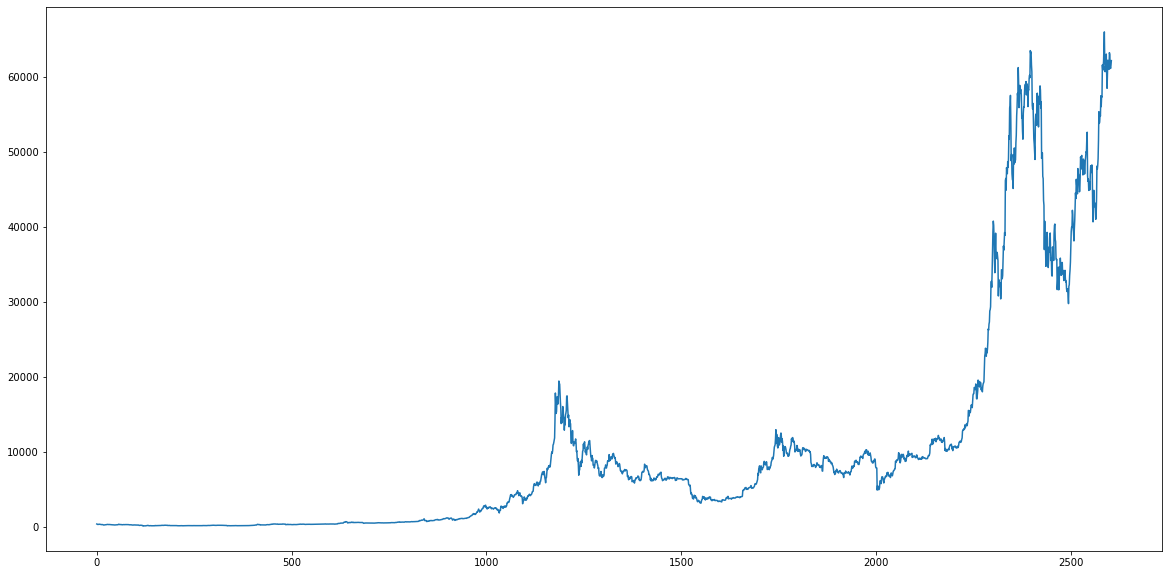

In [12]:
#Buy and hold BTC
url = 'https://query1.finance.yahoo.com/v8/finance/chart/BTC-USD?formatted=true&crumb=LqSYCwMewDq&lang=en-US&region=US&includeAdjustedClose=true&interval=1d&period1=1410912000&period2=1636243200&events=capitalGain|div|split&useYfid=true&corsDomain=finance.yahoo.com'
r = requests.get(url, headers=header)
soup = json.loads(str(BeautifulSoup(r.text, 'html.parser')))
closeList = soup['chart']['result'][0]['indicators']['quote'][0]['close']
closeList = [i for i in closeList if i != None]
changeInPrice = [np.log(closeList[i+1]/closeList[i]) for i in range(len(closeList)-1)]
negReturns = [i for i in changeInPrice if i<0]
print({
        'meanReturn' : np.mean(changeInPrice),
        'medianReturn' : np.median(changeInPrice),
        'sharpe' : (np.mean(changeInPrice)/np.std(changeInPrice))*np.sqrt(252),
        'absSharpe' : (abs(np.mean(changeInPrice))/np.std(changeInPrice))*np.sqrt(252),
        'sortino' : (np.mean(changeInPrice)/np.std(negReturns))*np.sqrt(252),
        'absSortino' : (abs(np.mean(changeInPrice))/np.std(negReturns))*np.sqrt(252),
        'totalNoOfDays' : len(changeInPrice),
        'inyears' : len(changeInPrice)/252
    })
plt.plot(closeList)